# Прогнозирование температуры звезды

Обсерватория «Небо на ладони» хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики:**
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- Тип звезды:
| Тип звезды                   | Номер, соответствующий типу |
|-----------------------------|----------------------------|
| Коричневый карлик            | 0                          |
| Красный карлик              | 1                          |
| Белый карлик                | 2                          |
| Звёзды главной последовательности | 3                  |
| Сверхгигант                 | 4                          |
| Гипергигант                 | 5                          |


**Справочная информация:**
- Светимость Солнца (англ. Average Luminosity of Sun): L₀ = 3.828 × 10²⁶ Вт
- Радиус Солнца (англ. Average Radius of Sun): R₀ = 6.9551 × 10⁸ м


**Задача:**
Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

### Установка программных пакетов и импорт необходимых библиотек.

In [1]:
#устанавливаем профайлер
!pip install ydata_profiling --quiet

In [2]:
#устанавливаем библиотеки

import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.compose import ColumnTransformer

from ydata_profiling import ProfileReport

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

SEED = 42
random.seed(SEED)                
np.random.seed(SEED)             
torch.manual_seed(SEED)          
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False     

### Загрузка данных.

In [3]:
data = pd.read_csv('/datasets/6_class.csv')

## Предобработка и анализ данных

### Ознакомление с данными.

#### Выводим основную информацию для датафрейма методом info() и первые 10 строк датасета.

In [4]:
data.info()

data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


#### Выводим основную информацию для датафрейма методом ProfileReport().

In [5]:
# ProfileReport(data)

#### Предварительные выводы:

**В данных выявлены следующие недостатки:**
- присутствуют избыточные данные, не относящиеся к признакам и целевому признаку;
- присутствуют неявные дубликаты;
- присутствуют количественные признаки с разными разбросами значений, которые необходимо масштабировать посредством стандартизации данных;
- присутствуют категориальные типы данных, которые необходимо преобразовать в численные для целей обучения нейросети.

### Предобработка данных.

#### Исключаем из датафрейма избыточные данные, не относящиеся к признакам.

In [6]:
data = data.drop('Unnamed: 0', axis=1)

#### Переименовываем столбцы в соответствии с требованиями PEP 8.

In [7]:
data = data.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
})

#### Исключаем неявные дубликаты из столбца star_color.

In [8]:
#выводим список уникальных значений
data['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [9]:
#приводим значения столбца к нижнему регистру и удаляем пробелы в начале и конце
data['star_color'] = data['star_color'].str.strip().str.lower()

In [10]:
#удаляем иные неявные дубликаты
data['star_color'] = data['star_color'].replace('blue white', 'blue-white')

In [11]:
data['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            8
yellowish white         3
yellowish               3
orange                  2
whitish                 2
orange-red              1
pale yellow orange      1
white-yellow            1
Name: star_color, dtype: int64

In [12]:
#удаляем классы цветов, который очень мало
data = data.loc[data['star_color'].isin(['red','blue','blue_white','yellow_white','white'])]

#### Производим категоризацию количественных данных.

##### Производим категоризацию данных по относительной светимости L/Lo.

In [14]:
# создаем функцию для категоризации светимости
def categorize_luminosity(luminosity):
    if luminosity < 10**-4:
        return 'ultra low luminosity'
    elif 10**-4 <= luminosity < 10**-2:
        return 'very low luminosity'
    elif 10**-2 <= luminosity < 1:
        return 'low luminosity'
    elif 1 <= luminosity < 10**2:
        return 'solar luminosity'
    elif 10**2 <= luminosity < 10**4:
        return 'high luminosity'
    elif 10**4 <= luminosity < 10**6:
        return 'very high luminosity'
    else:
        return 'ultra high luminosity'

In [15]:
#создаем новый столбец
data['luminosity_cat'] = data['luminosity'].apply(categorize_luminosity)

##### Производим категоризацию данных по относительному радиусу R/Ro.

In [16]:
# создаем функцию для категоризации радиуса
def categorize_radius(radius):
    if radius < 0.01:
        return 'ultra small radius'
    elif 0.01 <= radius < 0.1:
        return 'very small radius'
    elif 0.1 <= radius < 1:
        return 'small radius'
    elif 1 <= radius < 10:
        return 'solar radius'
    elif 10 <= radius < 100:
        return 'large radius'
    elif 100 <= radius < 1000:
        return 'very large radius'
    else:
        return 'ultra large radius'

In [17]:
# создаем новый столбец
data['radius_cat'] = data['radius'].apply(categorize_radius)

##### Производим категоризацию данных по абсолютной звёздной величине Mv.

In [18]:
# создаем функцию для категоризации абсолютной звёздной величины
def categorize_magnitude(mv):
    if mv < 0:
        return 'ultra bright'
    elif 0 <= mv < 5:
        return 'very bright'
    elif 5 <= mv < 10:
        return 'bright'
    elif 10 <= mv < 15:
        return 'dim'
    else:
        return 'very dim'

In [19]:
# создаем новый столбец
data['magnitude_cat'] = data['magnitude'].apply(categorize_magnitude)

### Анализ предобработанных данных.

In [20]:
# ProfileReport(data)

**Выводы:**

- Аномальные значения в количественных признаках не выявлены. Вместе с тем, в данных содержатся данные о звездах, имеющих характеристики из максимально широкого диапазона.

- Типы звезд представлены в данных равномерно.

- Выявлена наибольшая корелляция температуры от типа звезды (≈0.6), абсолютной звёздной величины (≈-0.5) и относительной светимости (≈0.5).

### Разбиваем датасет на обучающую и тестовую выборки.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['temperature']), 
    data.temperature, 
    test_size=0.3, 
    shuffle=True,
    random_state=SEED,
    stratify=data['star_type'])

### Нормализуем входные данные.

In [22]:
numeric = ['luminosity', 'radius', 'magnitude']
categorical = ['star_type', 'star_color', 'luminosity_cat', 'radius_cat', 'magnitude_cat']
col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric),
                                ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical)],
                                    remainder="passthrough"
                                      )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

### Преобразовываем данные в формат тензора.

In [23]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train.values).squeeze()
y_test = torch.FloatTensor(y_test.values).squeeze()

## Построение базовой нейронной сети

### Создаем функцию обучения и определения модели нейронной сети.

In [24]:
%%time

class StarTempPredictor(nn.Module):
    def __init__(self, layer_structure):
        super(StarTempPredictor, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(25, layer_structure[0]))  # входной слой

        for i in range(len(layer_structure) - 1):
            self.layers.append(nn.Linear(layer_structure[i], layer_structure[i+1]))  # скрытые слои

        self.layers.append(nn.Linear(layer_structure[-1], 1))  # выходной слой
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
            
        x = self.layers[-1](x)
        
        return x.squeeze()

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu') 
        nn.init.normal_(layer.bias, mean=0.5, std=0.7)

def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.008, early_stopping_patience=75):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    best_rmse = float('inf')
    best_model = copy.deepcopy(model.state_dict())

    no_improve_epochs = 0
    epochs = 0

    while True:
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
            rmse = torch.sqrt(test_loss).item()

            if epochs % 100 == 0:
                print(f'Эпоха {epochs} - train loss: {loss.item()}, test loss: {test_loss.item()}')

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epochs}')
            break
        epochs += 1
        if epochs >= 10000:
            print('Reached max number of epochs, stopping')
            break

    model.load_state_dict(best_model)
    return model, train_losses, test_losses

CPU times: user 29 µs, sys: 7 µs, total: 36 µs
Wall time: 38.9 µs


### Подбираем наилучшую архитектуру нейросети по количеству скрытых слоев и нейронов в них с выводом метрик и графиков обучения.

Эпоха 0 - train loss: 191320896.0, test loss: 191545664.0
Эпоха 100 - train loss: 40448504.0, test loss: 47096544.0
Эпоха 200 - train loss: 18741012.0, test loss: 19958438.0
Эпоха 300 - train loss: 15773863.0, test loss: 17074994.0
Эпоха 400 - train loss: 15425501.0, test loss: 16442161.0
Эпоха 500 - train loss: 15133017.0, test loss: 15901689.0
Эпоха 600 - train loss: 14666444.0, test loss: 15119013.0
Эпоха 700 - train loss: 14000685.0, test loss: 13584799.0
Эпоха 800 - train loss: 13199005.0, test loss: 12454980.0
Эпоха 900 - train loss: 12732022.0, test loss: 11741267.0
Эпоха 1000 - train loss: 12451737.0, test loss: 11836793.0
Early stopping at epoch 1083


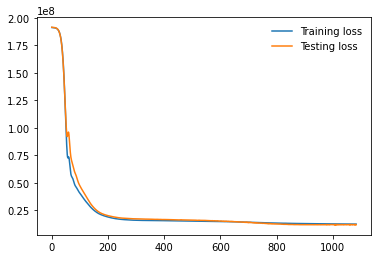

Эпоха 0 - train loss: 191326064.0, test loss: 191542784.0
Эпоха 100 - train loss: 39854720.0, test loss: 47319784.0
Эпоха 200 - train loss: 17133886.0, test loss: 18244074.0
Эпоха 300 - train loss: 15448735.0, test loss: 16577003.0
Эпоха 400 - train loss: 14971080.0, test loss: 16202199.0
Эпоха 500 - train loss: 13444806.0, test loss: 14329901.0
Эпоха 600 - train loss: 10946742.0, test loss: 10999896.0
Early stopping at epoch 699


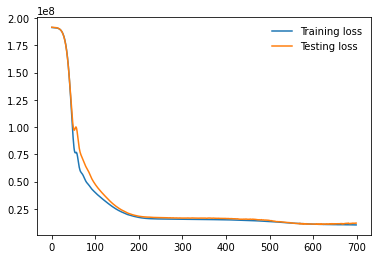

Эпоха 0 - train loss: 191319728.0, test loss: 191509904.0
Эпоха 100 - train loss: 31322508.0, test loss: 34992292.0
Эпоха 200 - train loss: 15931803.0, test loss: 17855838.0
Эпоха 300 - train loss: 15541576.0, test loss: 17246666.0
Эпоха 400 - train loss: 15401989.0, test loss: 17322316.0
Early stopping at epoch 437


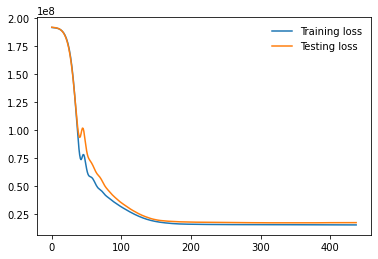

Эпоха 0 - train loss: 191164576.0, test loss: 191369344.0
Эпоха 100 - train loss: 36533744.0, test loss: 42014288.0
Эпоха 200 - train loss: 17792358.0, test loss: 19398392.0
Эпоха 300 - train loss: 15646395.0, test loss: 17494590.0
Эпоха 400 - train loss: 15469113.0, test loss: 17197392.0
Эпоха 500 - train loss: 15399022.0, test loss: 17009928.0
Эпоха 600 - train loss: 15331039.0, test loss: 16962334.0
Эпоха 700 - train loss: 15257143.0, test loss: 16802470.0
Эпоха 800 - train loss: 15168391.0, test loss: 16702989.0
Эпоха 900 - train loss: 15071399.0, test loss: 16483411.0
Эпоха 1000 - train loss: 14590651.0, test loss: 17274536.0
Early stopping at epoch 1017


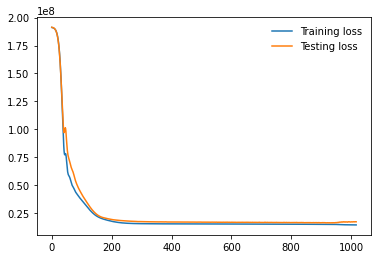

Эпоха 0 - train loss: 191213216.0, test loss: 191425520.0
Эпоха 100 - train loss: 34995376.0, test loss: 40120712.0
Эпоха 200 - train loss: 16671584.0, test loss: 18010676.0
Эпоха 300 - train loss: 15546658.0, test loss: 17016540.0
Эпоха 400 - train loss: 15433721.0, test loss: 16830338.0
Эпоха 500 - train loss: 15355316.0, test loss: 16783172.0
Эпоха 600 - train loss: 15260911.0, test loss: 16567848.0
Эпоха 700 - train loss: 15146335.0, test loss: 16501186.0
Эпоха 800 - train loss: 15007477.0, test loss: 16460898.0
Эпоха 900 - train loss: 14855672.0, test loss: 16302076.0
Эпоха 1000 - train loss: 14671929.0, test loss: 16052423.0
Early stopping at epoch 1068


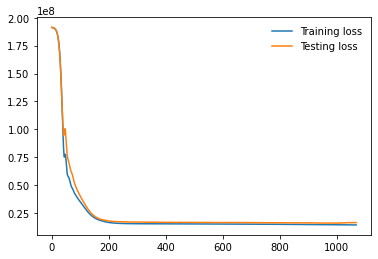

Эпоха 0 - train loss: 191344048.0, test loss: 191532624.0
Эпоха 100 - train loss: 31964992.0, test loss: 36106224.0
Эпоха 200 - train loss: 16049428.0, test loss: 17937576.0
Эпоха 300 - train loss: 15527829.0, test loss: 17114576.0
Эпоха 400 - train loss: 15308856.0, test loss: 16967294.0
Эпоха 500 - train loss: 15037766.0, test loss: 16735477.0
Эпоха 600 - train loss: 14696414.0, test loss: 16315249.0
Эпоха 700 - train loss: 14239599.0, test loss: 15961656.0
Эпоха 800 - train loss: 13735103.0, test loss: 15066818.0
Эпоха 900 - train loss: 13392015.0, test loss: 14530443.0
Эпоха 1000 - train loss: 13189287.0, test loss: 14209543.0
Early stopping at epoch 1098


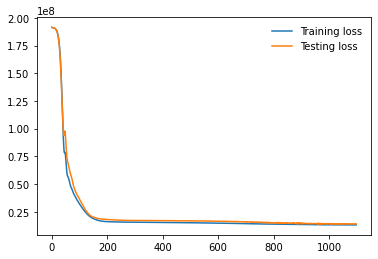

Эпоха 0 - train loss: 191284176.0, test loss: 191464416.0
Эпоха 100 - train loss: 37360500.0, test loss: 43559932.0
Эпоха 200 - train loss: 18109918.0, test loss: 19489454.0
Эпоха 300 - train loss: 15714110.0, test loss: 17487992.0
Эпоха 400 - train loss: 15496803.0, test loss: 17162620.0
Эпоха 500 - train loss: 15430601.0, test loss: 17168794.0
Early stopping at epoch 597


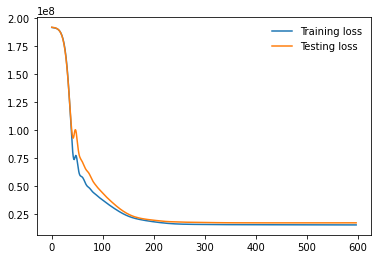

Эпоха 0 - train loss: 191228768.0, test loss: 191427408.0
Эпоха 100 - train loss: 29770802.0, test loss: 33272794.0
Эпоха 200 - train loss: 15642843.0, test loss: 17251408.0
Эпоха 300 - train loss: 15038123.0, test loss: 16513237.0
Эпоха 400 - train loss: 14511918.0, test loss: 16035554.0
Эпоха 500 - train loss: 13782879.0, test loss: 15485976.0
Эпоха 600 - train loss: 12824122.0, test loss: 13939879.0
Эпоха 700 - train loss: 11669023.0, test loss: 12444570.0
Эпоха 800 - train loss: 10470004.0, test loss: 12925265.0
Early stopping at epoch 813


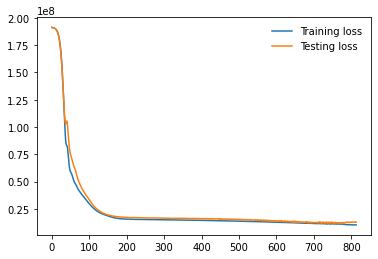

Эпоха 0 - train loss: 191306432.0, test loss: 191440912.0
Эпоха 100 - train loss: 29706792.0, test loss: 32973224.0
Эпоха 200 - train loss: 15834474.0, test loss: 17565748.0
Эпоха 300 - train loss: 15523820.0, test loss: 17066932.0
Эпоха 400 - train loss: 15393826.0, test loss: 16977726.0
Эпоха 500 - train loss: 15223404.0, test loss: 17051920.0
Early stopping at epoch 567


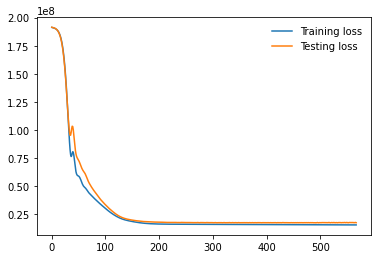

Эпоха 0 - train loss: 191289520.0, test loss: 191501344.0
Эпоха 100 - train loss: 42269832.0, test loss: 50806292.0
Эпоха 200 - train loss: 20030748.0, test loss: 21223228.0
Эпоха 300 - train loss: 15861823.0, test loss: 17661916.0
Эпоха 400 - train loss: 15514119.0, test loss: 17094450.0
Эпоха 500 - train loss: 15368831.0, test loss: 16862674.0
Эпоха 600 - train loss: 15223399.0, test loss: 16639145.0
Эпоха 700 - train loss: 15026009.0, test loss: 16498744.0
Эпоха 800 - train loss: 14725279.0, test loss: 16018276.0
Эпоха 900 - train loss: 14063129.0, test loss: 15028089.0
Эпоха 1000 - train loss: 13325553.0, test loss: 14076646.0
Эпоха 1100 - train loss: 12818656.0, test loss: 13486236.0
Эпоха 1200 - train loss: 12522539.0, test loss: 13108983.0
Эпоха 1300 - train loss: 12328866.0, test loss: 12819578.0
Early stopping at epoch 1336


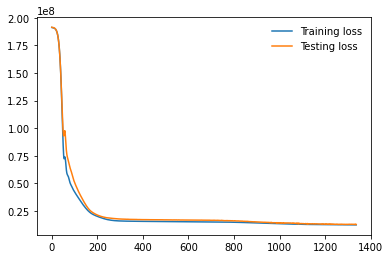

Эпоха 0 - train loss: 191347504.0, test loss: 191544736.0
Эпоха 100 - train loss: 33604608.0, test loss: 38132700.0
Эпоха 200 - train loss: 16342508.0, test loss: 17827558.0
Эпоха 300 - train loss: 15600836.0, test loss: 16916230.0
Эпоха 400 - train loss: 15259932.0, test loss: 16582136.0
Эпоха 500 - train loss: 14749046.0, test loss: 16381743.0
Эпоха 600 - train loss: 13855986.0, test loss: 15865707.0
Эпоха 700 - train loss: 12732924.0, test loss: 14938283.0
Эпоха 800 - train loss: 11339089.0, test loss: 15099630.0
Эпоха 900 - train loss: 9793355.0, test loss: 15300320.0
Эпоха 1000 - train loss: 8818908.0, test loss: 14579590.0
Early stopping at epoch 1025


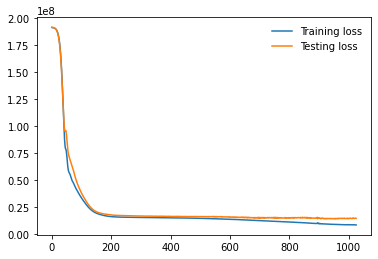

Эпоха 0 - train loss: 191409648.0, test loss: 191587344.0
Эпоха 100 - train loss: 31921826.0, test loss: 35412136.0
Эпоха 200 - train loss: 16562466.0, test loss: 18267756.0
Эпоха 300 - train loss: 15550592.0, test loss: 17437978.0
Эпоха 400 - train loss: 15389414.0, test loss: 17161666.0
Эпоха 500 - train loss: 14986777.0, test loss: 16702127.0
Эпоха 600 - train loss: 14422560.0, test loss: 16126891.0
Эпоха 700 - train loss: 14062772.0, test loss: 15829166.0
Эпоха 800 - train loss: 13651305.0, test loss: 15632936.0
Early stopping at epoch 800


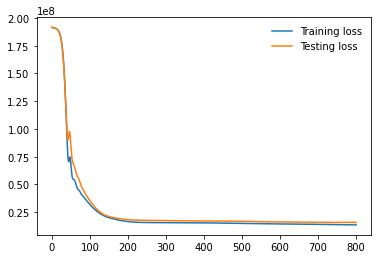

Эпоха 0 - train loss: 191281952.0, test loss: 191463552.0
Эпоха 100 - train loss: 36350080.0, test loss: 42686608.0
Эпоха 200 - train loss: 16443578.0, test loss: 17622066.0
Эпоха 300 - train loss: 15453566.0, test loss: 16429711.0
Эпоха 400 - train loss: 15178393.0, test loss: 16288270.0
Early stopping at epoch 424


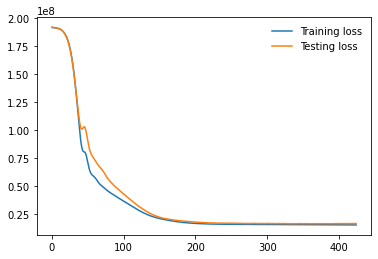

Эпоха 0 - train loss: 191379936.0, test loss: 191530832.0
Эпоха 100 - train loss: 30838644.0, test loss: 34847572.0
Эпоха 200 - train loss: 15790169.0, test loss: 17275266.0
Эпоха 300 - train loss: 15513342.0, test loss: 16903722.0
Эпоха 400 - train loss: 15368580.0, test loss: 16513759.0
Early stopping at epoch 470


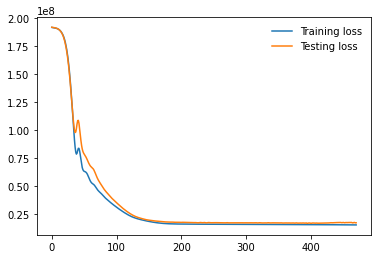

Эпоха 0 - train loss: 191281872.0, test loss: 191432640.0
Эпоха 100 - train loss: 28562256.0, test loss: 31484400.0
Эпоха 200 - train loss: 15637604.0, test loss: 17328866.0
Эпоха 300 - train loss: 15046433.0, test loss: 16543863.0
Эпоха 400 - train loss: 14485727.0, test loss: 15849926.0
Эпоха 500 - train loss: 13672554.0, test loss: 15426376.0
Эпоха 600 - train loss: 12558151.0, test loss: 14563972.0
Эпоха 700 - train loss: 11428881.0, test loss: 12984527.0
Эпоха 800 - train loss: 10729692.0, test loss: 12730771.0
Эпоха 900 - train loss: 10309972.0, test loss: 12041734.0
Эпоха 1000 - train loss: 10287810.0, test loss: 11685690.0
Early stopping at epoch 1073


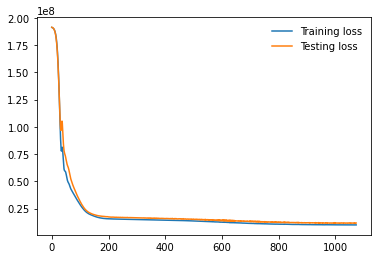

Эпоха 0 - train loss: 191397088.0, test loss: 191509792.0
Эпоха 100 - train loss: 36946876.0, test loss: 42427728.0
Эпоха 200 - train loss: 16861716.0, test loss: 18302576.0
Эпоха 300 - train loss: 15510644.0, test loss: 17448978.0
Эпоха 400 - train loss: 15334097.0, test loss: 17393874.0
Эпоха 500 - train loss: 15079181.0, test loss: 17200190.0
Эпоха 600 - train loss: 14687883.0, test loss: 16697894.0
Эпоха 700 - train loss: 14032923.0, test loss: 16070458.0
Эпоха 800 - train loss: 13116580.0, test loss: 14854107.0
Эпоха 900 - train loss: 11097423.0, test loss: 13879691.0
Эпоха 1000 - train loss: 9826108.0, test loss: 12533551.0
Эпоха 1100 - train loss: 9498328.0, test loss: 12435285.0
Early stopping at epoch 1152


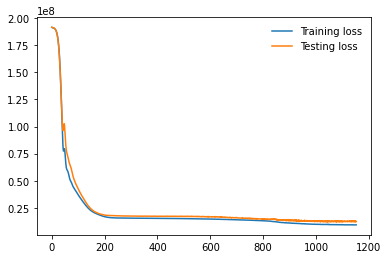

Эпоха 0 - train loss: 191290816.0, test loss: 191446752.0
Эпоха 100 - train loss: 26480876.0, test loss: 28740770.0
Эпоха 200 - train loss: 15687970.0, test loss: 17168644.0
Эпоха 300 - train loss: 15460388.0, test loss: 16772863.0
Эпоха 400 - train loss: 15332444.0, test loss: 16871472.0
Early stopping at epoch 401


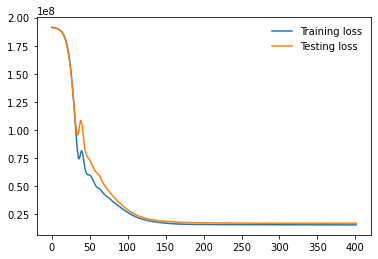

Эпоха 0 - train loss: 191274736.0, test loss: 191473216.0
Эпоха 100 - train loss: 29480344.0, test loss: 32645160.0
Эпоха 200 - train loss: 15871973.0, test loss: 17125700.0
Эпоха 300 - train loss: 15557294.0, test loss: 16820942.0
Эпоха 400 - train loss: 15463667.0, test loss: 16677515.0
Эпоха 500 - train loss: 15261241.0, test loss: 16541690.0
Эпоха 600 - train loss: 14736646.0, test loss: 16272463.0
Эпоха 700 - train loss: 13712258.0, test loss: 15381736.0
Эпоха 800 - train loss: 12832010.0, test loss: 14749749.0
Эпоха 900 - train loss: 11651506.0, test loss: 12973024.0
Эпоха 1000 - train loss: 10269050.0, test loss: 12652140.0
Эпоха 1100 - train loss: 8788374.0, test loss: 11728434.0
Early stopping at epoch 1129


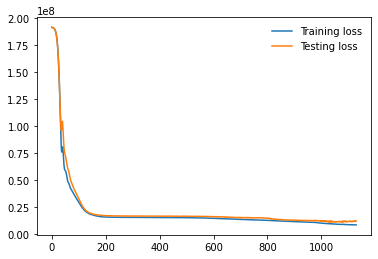

Эпоха 0 - train loss: 191218768.0, test loss: 191417968.0
Эпоха 100 - train loss: 35919540.0, test loss: 41163628.0
Эпоха 200 - train loss: 17179724.0, test loss: 18574794.0
Эпоха 300 - train loss: 15570973.0, test loss: 17122742.0
Эпоха 400 - train loss: 15408785.0, test loss: 16714360.0
Эпоха 500 - train loss: 15304714.0, test loss: 16635650.0
Эпоха 600 - train loss: 15181746.0, test loss: 16371533.0
Early stopping at epoch 670


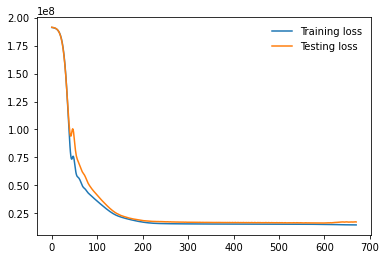

Эпоха 0 - train loss: 191155376.0, test loss: 191337136.0
Эпоха 100 - train loss: 32309110.0, test loss: 36738396.0
Эпоха 200 - train loss: 16657693.0, test loss: 17866392.0
Эпоха 300 - train loss: 15627338.0, test loss: 16808424.0
Эпоха 400 - train loss: 15374801.0, test loss: 16536072.0
Early stopping at epoch 475


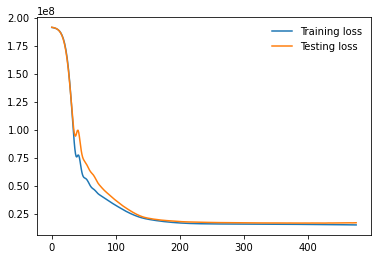

Эпоха 0 - train loss: 191310624.0, test loss: 191506848.0
Эпоха 100 - train loss: 33675720.0, test loss: 37707508.0
Эпоха 200 - train loss: 16037423.0, test loss: 17043454.0
Эпоха 300 - train loss: 15515132.0, test loss: 16406023.0
Эпоха 400 - train loss: 15365112.0, test loss: 16278420.0
Эпоха 500 - train loss: 15206159.0, test loss: 16075880.0
Эпоха 600 - train loss: 14932453.0, test loss: 15754711.0
Эпоха 700 - train loss: 14539403.0, test loss: 15247172.0
Эпоха 800 - train loss: 13921110.0, test loss: 14528437.0
Эпоха 900 - train loss: 12913685.0, test loss: 13622581.0
Эпоха 1000 - train loss: 11131431.0, test loss: 12909871.0
Эпоха 1100 - train loss: 9666039.0, test loss: 12650195.0
Эпоха 1200 - train loss: 8652356.0, test loss: 12559436.0
Early stopping at epoch 1254


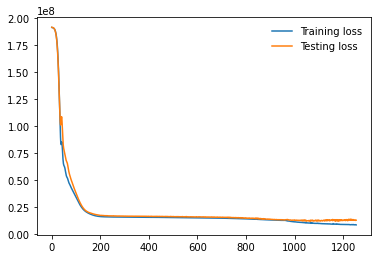

Эпоха 0 - train loss: 191273904.0, test loss: 191463136.0
Эпоха 100 - train loss: 31768774.0, test loss: 35771280.0
Эпоха 200 - train loss: 16519656.0, test loss: 17587030.0
Эпоха 300 - train loss: 15491303.0, test loss: 16678462.0
Эпоха 400 - train loss: 15334334.0, test loss: 16447367.0
Эпоха 500 - train loss: 15170708.0, test loss: 16367556.0
Эпоха 600 - train loss: 14876633.0, test loss: 16236027.0
Эпоха 700 - train loss: 14187448.0, test loss: 15811623.0
Эпоха 800 - train loss: 12774905.0, test loss: 15033576.0
Эпоха 900 - train loss: 11086324.0, test loss: 14208710.0
Эпоха 1000 - train loss: 10129158.0, test loss: 13375204.0
Эпоха 1100 - train loss: 9343183.0, test loss: 12790529.0
Эпоха 1200 - train loss: 8913774.0, test loss: 13368796.0
Early stopping at epoch 1216


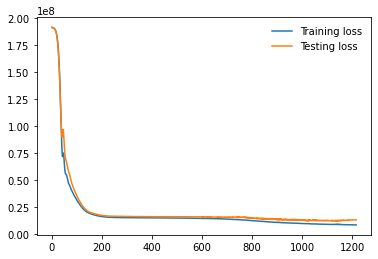

Эпоха 0 - train loss: 191340608.0, test loss: 191510000.0
Эпоха 100 - train loss: 32509858.0, test loss: 36581312.0
Эпоха 200 - train loss: 16247891.0, test loss: 17109256.0
Эпоха 300 - train loss: 15477551.0, test loss: 16342908.0
Эпоха 400 - train loss: 15273841.0, test loss: 16340338.0
Early stopping at epoch 412


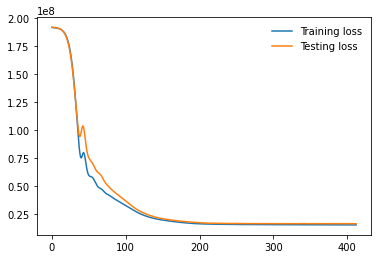

Эпоха 0 - train loss: 191292832.0, test loss: 191452480.0
Эпоха 100 - train loss: 28593516.0, test loss: 32286348.0
Эпоха 200 - train loss: 16038142.0, test loss: 17856780.0
Эпоха 300 - train loss: 15462710.0, test loss: 16907884.0
Эпоха 400 - train loss: 15343826.0, test loss: 16633474.0
Эпоха 500 - train loss: 15173229.0, test loss: 16693844.0
Early stopping at epoch 524


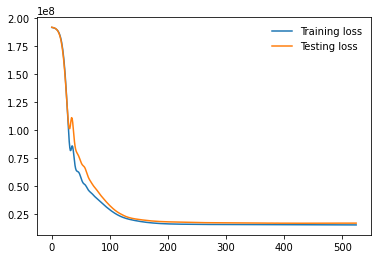

Эпоха 0 - train loss: 191259856.0, test loss: 191386288.0
Эпоха 100 - train loss: 29850558.0, test loss: 33855548.0
Эпоха 200 - train loss: 15865233.0, test loss: 17770084.0
Эпоха 300 - train loss: 15438449.0, test loss: 17146092.0
Эпоха 400 - train loss: 15253314.0, test loss: 16775253.0
Эпоха 500 - train loss: 15079023.0, test loss: 16666726.0
Эпоха 600 - train loss: 14844845.0, test loss: 16275499.0
Эпоха 700 - train loss: 14468401.0, test loss: 15895861.0
Эпоха 800 - train loss: 13430697.0, test loss: 14344391.0
Эпоха 900 - train loss: 12690311.0, test loss: 13085544.0
Эпоха 1000 - train loss: 12097514.0, test loss: 12160369.0
Эпоха 1100 - train loss: 11725766.0, test loss: 11390125.0
Эпоха 1200 - train loss: 11469974.0, test loss: 10887002.0
Эпоха 1300 - train loss: 11086777.0, test loss: 10425683.0
Эпоха 1400 - train loss: 10300886.0, test loss: 10255974.0
Early stopping at epoch 1458


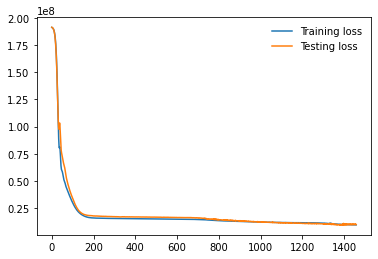

Эпоха 0 - train loss: 191216608.0, test loss: 191365456.0
Эпоха 100 - train loss: 26067868.0, test loss: 28368836.0
Эпоха 200 - train loss: 15727349.0, test loss: 17381868.0
Эпоха 300 - train loss: 15488737.0, test loss: 17198254.0
Early stopping at epoch 335


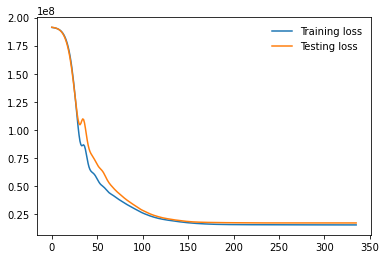

Эпоха 0 - train loss: 191407648.0, test loss: 191496480.0
Эпоха 100 - train loss: 29053420.0, test loss: 32299814.0
Эпоха 200 - train loss: 15685211.0, test loss: 17796762.0
Эпоха 300 - train loss: 15309383.0, test loss: 17127932.0
Эпоха 400 - train loss: 15009105.0, test loss: 16841386.0
Эпоха 500 - train loss: 14359463.0, test loss: 16384429.0
Эпоха 600 - train loss: 13605039.0, test loss: 15244648.0
Эпоха 700 - train loss: 13018121.0, test loss: 14951520.0
Early stopping at epoch 701


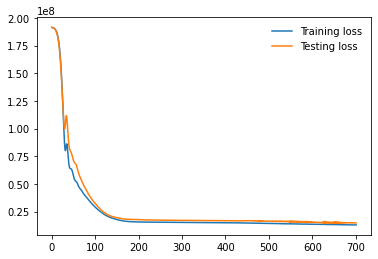

Эпоха 0 - train loss: 191347008.0, test loss: 191559776.0
Эпоха 100 - train loss: 41636212.0, test loss: 49092448.0
Эпоха 200 - train loss: 18754792.0, test loss: 19972236.0
Эпоха 300 - train loss: 15738935.0, test loss: 17290544.0
Эпоха 400 - train loss: 15416484.0, test loss: 16791792.0
Эпоха 500 - train loss: 15311439.0, test loss: 16655035.0
Эпоха 600 - train loss: 15161835.0, test loss: 16586329.0
Эпоха 700 - train loss: 14694028.0, test loss: 15914031.0
Эпоха 800 - train loss: 14057021.0, test loss: 15098075.0
Эпоха 900 - train loss: 13225925.0, test loss: 14389975.0
Эпоха 1000 - train loss: 12370055.0, test loss: 13045073.0
Эпоха 1100 - train loss: 11893129.0, test loss: 12551860.0
Эпоха 1200 - train loss: 11681163.0, test loss: 12370891.0
Эпоха 1300 - train loss: 11508408.0, test loss: 12194233.0
Early stopping at epoch 1326


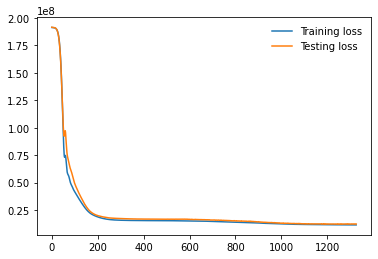

Эпоха 0 - train loss: 191358352.0, test loss: 191554896.0
Эпоха 100 - train loss: 38318112.0, test loss: 44371088.0
Эпоха 200 - train loss: 18671756.0, test loss: 19719620.0
Эпоха 300 - train loss: 15737786.0, test loss: 16916310.0
Эпоха 400 - train loss: 15490411.0, test loss: 16607151.0
Эпоха 500 - train loss: 15350401.0, test loss: 16495929.0
Эпоха 600 - train loss: 15203433.0, test loss: 16425709.0
Эпоха 700 - train loss: 15049663.0, test loss: 16295474.0
Эпоха 800 - train loss: 14865174.0, test loss: 16112171.0
Эпоха 900 - train loss: 14583867.0, test loss: 16055200.0
Эпоха 1000 - train loss: 14329033.0, test loss: 15999682.0
Эпоха 1100 - train loss: 14107598.0, test loss: 15943559.0
Эпоха 1200 - train loss: 13893242.0, test loss: 15756393.0
Эпоха 1300 - train loss: 13709354.0, test loss: 15552321.0
Эпоха 1400 - train loss: 13552607.0, test loss: 15378917.0
Эпоха 1500 - train loss: 13384627.0, test loss: 14965159.0
Эпоха 1600 - train loss: 13210274.0, test loss: 14307959.0
Эпоха 1

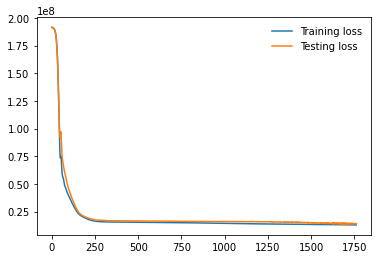

Эпоха 0 - train loss: 191348688.0, test loss: 191559584.0
Эпоха 100 - train loss: 34156640.0, test loss: 38758004.0
Эпоха 200 - train loss: 16325774.0, test loss: 17943748.0
Эпоха 300 - train loss: 15462042.0, test loss: 16833156.0
Эпоха 400 - train loss: 15289690.0, test loss: 16632033.0
Эпоха 500 - train loss: 15143290.0, test loss: 16548198.0
Эпоха 600 - train loss: 14991061.0, test loss: 16460023.0
Эпоха 700 - train loss: 14809846.0, test loss: 16291934.0
Эпоха 800 - train loss: 14566965.0, test loss: 16221385.0
Early stopping at epoch 837


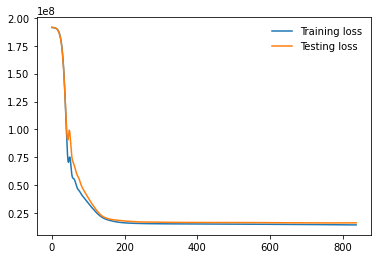

Эпоха 0 - train loss: 191231808.0, test loss: 191438672.0
Эпоха 100 - train loss: 37142560.0, test loss: 42668688.0
Эпоха 200 - train loss: 17224614.0, test loss: 18639682.0
Эпоха 300 - train loss: 15595316.0, test loss: 17320754.0
Эпоха 400 - train loss: 15352777.0, test loss: 16857282.0
Эпоха 500 - train loss: 15158336.0, test loss: 16586445.0
Эпоха 600 - train loss: 14874067.0, test loss: 16251942.0
Эпоха 700 - train loss: 14539795.0, test loss: 15798540.0
Early stopping at epoch 793


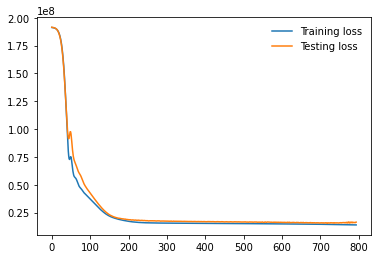

Эпоха 0 - train loss: 191215472.0, test loss: 191385568.0
Эпоха 100 - train loss: 32806326.0, test loss: 36869000.0
Эпоха 200 - train loss: 16030606.0, test loss: 17713622.0
Эпоха 300 - train loss: 15395159.0, test loss: 16853688.0
Эпоха 400 - train loss: 15224995.0, test loss: 16793328.0
Эпоха 500 - train loss: 14933025.0, test loss: 16724271.0
Эпоха 600 - train loss: 14291462.0, test loss: 15725611.0
Эпоха 700 - train loss: 13678692.0, test loss: 15935567.0
Эпоха 800 - train loss: 13124038.0, test loss: 14532395.0
Эпоха 900 - train loss: 12537996.0, test loss: 13931699.0
Эпоха 1000 - train loss: 10207651.0, test loss: 13162225.0
Early stopping at epoch 1038


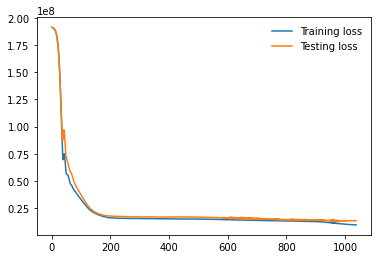

Эпоха 0 - train loss: 191310064.0, test loss: 191485456.0
Эпоха 100 - train loss: 30951838.0, test loss: 34516760.0
Эпоха 200 - train loss: 15758915.0, test loss: 17510570.0
Эпоха 300 - train loss: 15317106.0, test loss: 16947022.0
Эпоха 400 - train loss: 14737851.0, test loss: 16610989.0
Эпоха 500 - train loss: 13830910.0, test loss: 15107889.0
Эпоха 600 - train loss: 13208349.0, test loss: 14022343.0
Эпоха 700 - train loss: 12843230.0, test loss: 13042814.0
Эпоха 800 - train loss: 12354953.0, test loss: 12108427.0
Эпоха 900 - train loss: 12136263.0, test loss: 11653406.0
Эпоха 1000 - train loss: 12004569.0, test loss: 11311108.0
Эпоха 1100 - train loss: 11889893.0, test loss: 11001876.0
Эпоха 1200 - train loss: 11771930.0, test loss: 10814195.0
Эпоха 1300 - train loss: 11618338.0, test loss: 10562577.0
Эпоха 1400 - train loss: 11521589.0, test loss: 10492564.0
Эпоха 1500 - train loss: 11879710.0, test loss: 10307426.0
Эпоха 1600 - train loss: 11437182.0, test loss: 10181767.0
Эпоха 1

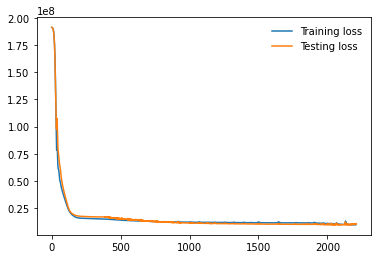

Эпоха 0 - train loss: 191205424.0, test loss: 191398496.0
Эпоха 100 - train loss: 29677818.0, test loss: 33238674.0
Эпоха 200 - train loss: 15995142.0, test loss: 17547122.0
Эпоха 300 - train loss: 15419011.0, test loss: 16857128.0
Эпоха 400 - train loss: 14968060.0, test loss: 16519422.0
Эпоха 500 - train loss: 13957935.0, test loss: 15773717.0
Эпоха 600 - train loss: 12974260.0, test loss: 14686808.0
Эпоха 700 - train loss: 11928396.0, test loss: 13521138.0
Эпоха 800 - train loss: 10107337.0, test loss: 12231563.0
Early stopping at epoch 855


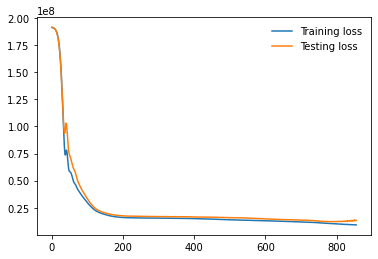

Эпоха 0 - train loss: 191289232.0, test loss: 191459344.0
Эпоха 100 - train loss: 33603920.0, test loss: 38046544.0
Эпоха 200 - train loss: 16049589.0, test loss: 17572296.0
Эпоха 300 - train loss: 15478998.0, test loss: 16911886.0
Эпоха 400 - train loss: 15288437.0, test loss: 16699356.0
Эпоха 500 - train loss: 15064362.0, test loss: 16571379.0
Эпоха 600 - train loss: 14743537.0, test loss: 16392591.0
Эпоха 700 - train loss: 14230150.0, test loss: 15930408.0
Эпоха 800 - train loss: 13850100.0, test loss: 15487010.0
Эпоха 900 - train loss: 13523976.0, test loss: 14230383.0
Early stopping at epoch 936


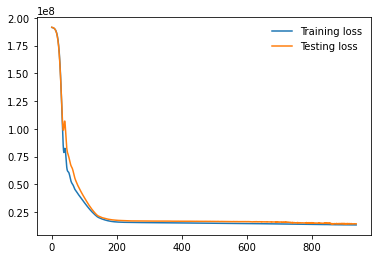

Эпоха 0 - train loss: 191317664.0, test loss: 191453904.0
Эпоха 100 - train loss: 27434520.0, test loss: 30590478.0
Эпоха 200 - train loss: 15708933.0, test loss: 17473542.0
Эпоха 300 - train loss: 15292992.0, test loss: 16879016.0
Эпоха 400 - train loss: 14869316.0, test loss: 16471770.0
Эпоха 500 - train loss: 13955405.0, test loss: 15426196.0
Эпоха 600 - train loss: 12967981.0, test loss: 13956703.0
Эпоха 700 - train loss: 12287651.0, test loss: 14821687.0
Early stopping at epoch 709


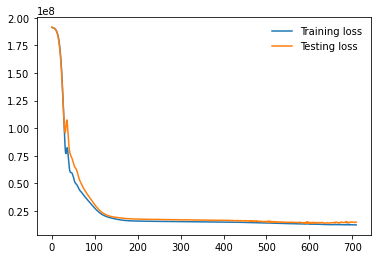

Эпоха 0 - train loss: 191317136.0, test loss: 191494320.0
Эпоха 100 - train loss: 31863646.0, test loss: 36278808.0
Эпоха 200 - train loss: 16340002.0, test loss: 17947934.0
Эпоха 300 - train loss: 15553822.0, test loss: 16857354.0
Эпоха 400 - train loss: 15391585.0, test loss: 16540174.0
Эпоха 500 - train loss: 15216762.0, test loss: 16357414.0
Эпоха 600 - train loss: 15035954.0, test loss: 16142822.0
Эпоха 700 - train loss: 14816478.0, test loss: 15959220.0
Эпоха 800 - train loss: 14527592.0, test loss: 15735617.0
Эпоха 900 - train loss: 14139691.0, test loss: 15675291.0
Эпоха 1000 - train loss: 13845844.0, test loss: 15562679.0
Эпоха 1100 - train loss: 13655177.0, test loss: 15156302.0
Эпоха 1200 - train loss: 13305611.0, test loss: 14386636.0
Early stopping at epoch 1210


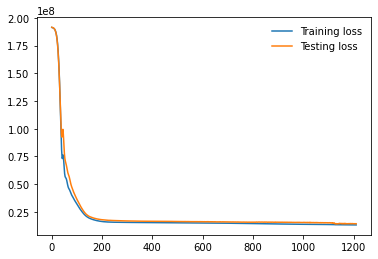

Эпоха 0 - train loss: 191295280.0, test loss: 191513312.0
Эпоха 100 - train loss: 32224136.0, test loss: 36567504.0
Эпоха 200 - train loss: 16497363.0, test loss: 17921720.0
Эпоха 300 - train loss: 15468118.0, test loss: 17007426.0
Эпоха 400 - train loss: 15297900.0, test loss: 16831366.0
Эпоха 500 - train loss: 15111299.0, test loss: 16720801.0
Early stopping at epoch 587


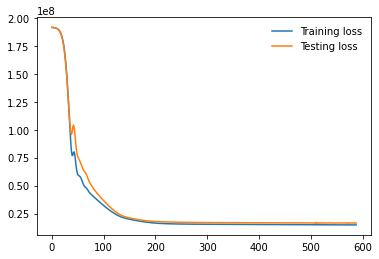

Эпоха 0 - train loss: 191310112.0, test loss: 191504816.0
Эпоха 100 - train loss: 31556300.0, test loss: 35252972.0
Эпоха 200 - train loss: 16280046.0, test loss: 17920074.0
Эпоха 300 - train loss: 15427305.0, test loss: 17245156.0
Эпоха 400 - train loss: 15059788.0, test loss: 16930870.0
Эпоха 500 - train loss: 14526731.0, test loss: 16495488.0
Эпоха 600 - train loss: 13754370.0, test loss: 15833920.0
Эпоха 700 - train loss: 12744456.0, test loss: 14656296.0
Эпоха 800 - train loss: 11704217.0, test loss: 13630014.0
Эпоха 900 - train loss: 10963314.0, test loss: 13765323.0
Эпоха 1000 - train loss: 10018955.0, test loss: 12617517.0
Early stopping at epoch 1043


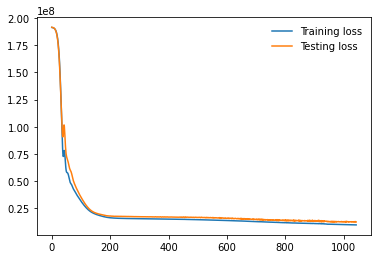

Эпоха 0 - train loss: 191286992.0, test loss: 191487968.0
Эпоха 100 - train loss: 29913086.0, test loss: 33223272.0
Эпоха 200 - train loss: 16408509.0, test loss: 17660906.0
Эпоха 300 - train loss: 15478954.0, test loss: 16944452.0
Эпоха 400 - train loss: 15286556.0, test loss: 16751159.0
Эпоха 500 - train loss: 14994248.0, test loss: 16340888.0
Эпоха 600 - train loss: 14511812.0, test loss: 15295777.0
Эпоха 700 - train loss: 14041346.0, test loss: 14943493.0
Эпоха 800 - train loss: 13554285.0, test loss: 14201389.0
Эпоха 900 - train loss: 13101948.0, test loss: 13341504.0
Эпоха 1000 - train loss: 12914816.0, test loss: 12927845.0
Эпоха 1100 - train loss: 12835313.0, test loss: 12827194.0
Early stopping at epoch 1189


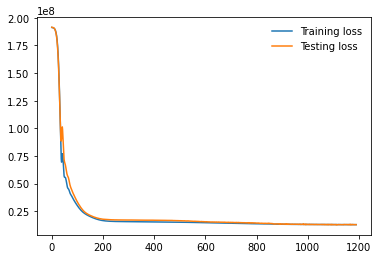

Эпоха 0 - train loss: 191288400.0, test loss: 191455664.0
Эпоха 100 - train loss: 27915832.0, test loss: 30478296.0
Эпоха 200 - train loss: 16018682.0, test loss: 17450066.0
Эпоха 300 - train loss: 15525707.0, test loss: 16999672.0
Early stopping at epoch 364


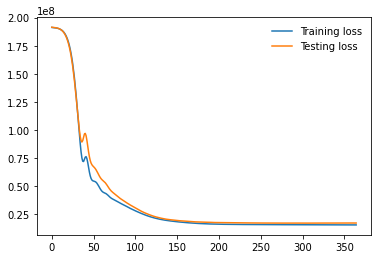

Эпоха 0 - train loss: 191264736.0, test loss: 191457472.0
Эпоха 100 - train loss: 25139016.0, test loss: 27289724.0
Эпоха 200 - train loss: 15687292.0, test loss: 16928628.0
Эпоха 300 - train loss: 15269590.0, test loss: 16681707.0
Эпоха 400 - train loss: 14930157.0, test loss: 16618695.0
Эпоха 500 - train loss: 14490297.0, test loss: 16314881.0
Эпоха 600 - train loss: 14034141.0, test loss: 15840179.0
Эпоха 700 - train loss: 13632611.0, test loss: 15325216.0
Эпоха 800 - train loss: 13266799.0, test loss: 14581965.0
Эпоха 900 - train loss: 12987944.0, test loss: 13815438.0
Эпоха 1000 - train loss: 12745695.0, test loss: 13436134.0
Эпоха 1100 - train loss: 12490861.0, test loss: 13504978.0
Early stopping at epoch 1146


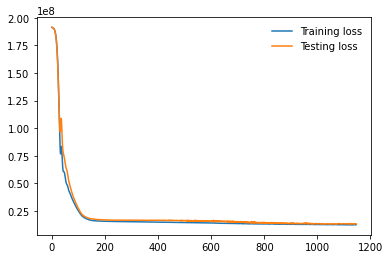

Эпоха 0 - train loss: 191317536.0, test loss: 191494128.0
Эпоха 100 - train loss: 26100728.0, test loss: 28711140.0
Эпоха 200 - train loss: 15831214.0, test loss: 17617802.0
Эпоха 300 - train loss: 15400268.0, test loss: 17120842.0
Эпоха 400 - train loss: 15245867.0, test loss: 16983190.0
Эпоха 500 - train loss: 15086652.0, test loss: 16828406.0
Early stopping at epoch 567


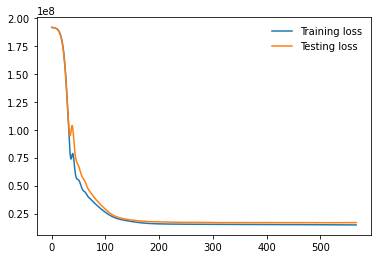

Эпоха 0 - train loss: 191281696.0, test loss: 191427392.0
Эпоха 100 - train loss: 22704444.0, test loss: 24348390.0
Эпоха 200 - train loss: 15619453.0, test loss: 17335996.0
Эпоха 300 - train loss: 15336475.0, test loss: 17024754.0
Эпоха 400 - train loss: 15131179.0, test loss: 16477670.0
Эпоха 500 - train loss: 14747222.0, test loss: 16092601.0
Эпоха 600 - train loss: 14230501.0, test loss: 15382519.0
Эпоха 700 - train loss: 13393001.0, test loss: 14180691.0
Эпоха 800 - train loss: 11774635.0, test loss: 12015157.0
Эпоха 900 - train loss: 9516694.0, test loss: 11377393.0
Early stopping at epoch 985


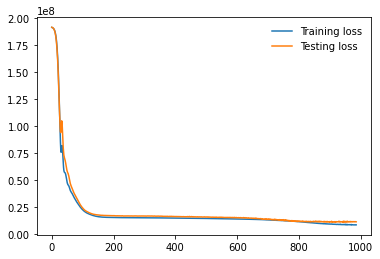

Эпоха 0 - train loss: 191266976.0, test loss: 191389904.0
Эпоха 100 - train loss: 25275412.0, test loss: 27521418.0
Эпоха 200 - train loss: 15707333.0, test loss: 17179080.0
Эпоха 300 - train loss: 15363207.0, test loss: 16548465.0
Эпоха 400 - train loss: 14996177.0, test loss: 16286603.0
Эпоха 500 - train loss: 13944561.0, test loss: 15699369.0
Эпоха 600 - train loss: 12511959.0, test loss: 15293989.0
Early stopping at epoch 640


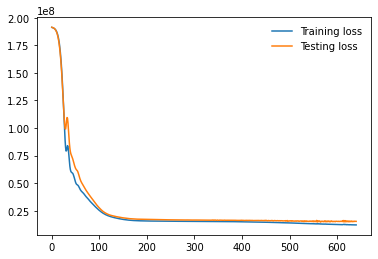

Эпоха 0 - train loss: 191318000.0, test loss: 191538832.0
Эпоха 100 - train loss: 36072432.0, test loss: 41306980.0
Эпоха 200 - train loss: 17909156.0, test loss: 19137376.0
Эпоха 300 - train loss: 15738254.0, test loss: 17403678.0
Эпоха 400 - train loss: 15533061.0, test loss: 17134500.0
Эпоха 500 - train loss: 15449147.0, test loss: 17072050.0
Early stopping at epoch 598


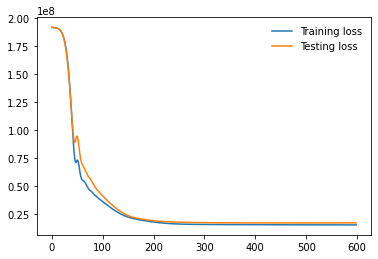

Эпоха 0 - train loss: 191311360.0, test loss: 191458816.0
Эпоха 100 - train loss: 27788776.0, test loss: 30536674.0
Эпоха 200 - train loss: 15960220.0, test loss: 17651576.0
Эпоха 300 - train loss: 15445920.0, test loss: 16803912.0
Эпоха 400 - train loss: 15247356.0, test loss: 16608885.0
Эпоха 500 - train loss: 14974425.0, test loss: 16255044.0
Эпоха 600 - train loss: 14540215.0, test loss: 15701038.0
Эпоха 700 - train loss: 13844057.0, test loss: 14770611.0
Эпоха 800 - train loss: 12803965.0, test loss: 12807273.0
Эпоха 900 - train loss: 11411539.0, test loss: 11192476.0
Эпоха 1000 - train loss: 9475975.0, test loss: 10060877.0
Early stopping at epoch 1058


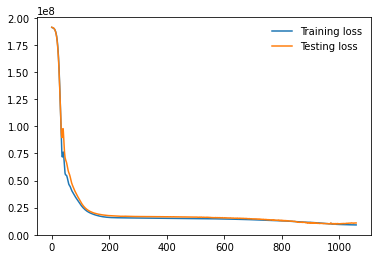

Эпоха 0 - train loss: 191280288.0, test loss: 191458912.0
Эпоха 100 - train loss: 27444334.0, test loss: 29863666.0
Эпоха 200 - train loss: 15977905.0, test loss: 17856648.0
Эпоха 300 - train loss: 15393401.0, test loss: 17238660.0
Эпоха 400 - train loss: 15217940.0, test loss: 17172558.0
Эпоха 500 - train loss: 15028266.0, test loss: 17161664.0
Early stopping at epoch 501


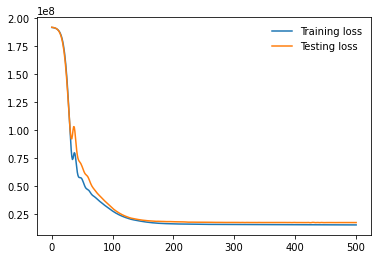

Эпоха 0 - train loss: 191323008.0, test loss: 191520560.0
Эпоха 100 - train loss: 33020800.0, test loss: 37240752.0
Эпоха 200 - train loss: 17002066.0, test loss: 18279792.0
Эпоха 300 - train loss: 15594711.0, test loss: 17116510.0
Эпоха 400 - train loss: 15443639.0, test loss: 16856930.0
Эпоха 500 - train loss: 15341901.0, test loss: 16691279.0
Эпоха 600 - train loss: 15143697.0, test loss: 16758127.0
Early stopping at epoch 620


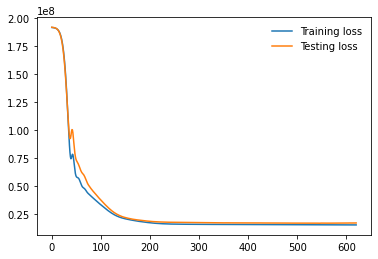

Эпоха 0 - train loss: 191367280.0, test loss: 191550224.0
Эпоха 100 - train loss: 28017670.0, test loss: 31342758.0
Эпоха 200 - train loss: 15746664.0, test loss: 17409574.0
Эпоха 300 - train loss: 15340348.0, test loss: 16829940.0
Эпоха 400 - train loss: 15180360.0, test loss: 16781178.0
Эпоха 500 - train loss: 14973749.0, test loss: 16672495.0
Эпоха 600 - train loss: 14619113.0, test loss: 16500539.0
Early stopping at epoch 634


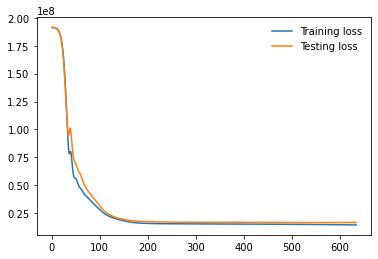

Эпоха 0 - train loss: 191333792.0, test loss: 191498528.0
Эпоха 100 - train loss: 25080234.0, test loss: 27610524.0
Эпоха 200 - train loss: 15775644.0, test loss: 17584404.0
Эпоха 300 - train loss: 15456035.0, test loss: 17053626.0
Эпоха 400 - train loss: 15288413.0, test loss: 16850520.0
Эпоха 500 - train loss: 15064835.0, test loss: 16821694.0
Эпоха 600 - train loss: 14742141.0, test loss: 16543010.0
Эпоха 700 - train loss: 14134468.0, test loss: 15601679.0
Эпоха 800 - train loss: 13210183.0, test loss: 14202530.0
Эпоха 900 - train loss: 11969353.0, test loss: 13730338.0
Early stopping at epoch 955


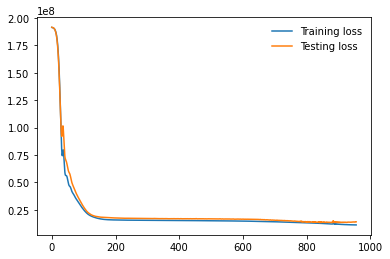

Эпоха 0 - train loss: 191287296.0, test loss: 191464896.0
Эпоха 100 - train loss: 25998906.0, test loss: 28007560.0
Эпоха 200 - train loss: 15530060.0, test loss: 17007134.0
Эпоха 300 - train loss: 15252137.0, test loss: 16667962.0
Эпоха 400 - train loss: 15007260.0, test loss: 16450955.0
Эпоха 500 - train loss: 14552083.0, test loss: 16177413.0
Эпоха 600 - train loss: 14034851.0, test loss: 15427602.0
Эпоха 700 - train loss: 13710203.0, test loss: 14777577.0
Эпоха 800 - train loss: 13419973.0, test loss: 14429380.0
Эпоха 900 - train loss: 12960620.0, test loss: 13616737.0
Эпоха 1000 - train loss: 12758230.0, test loss: 12696742.0
Эпоха 1100 - train loss: 12437853.0, test loss: 12506692.0
Эпоха 1200 - train loss: 12114715.0, test loss: 11969297.0
Эпоха 1300 - train loss: 11789387.0, test loss: 11826157.0
Эпоха 1400 - train loss: 10636032.0, test loss: 11699847.0
Early stopping at epoch 1470


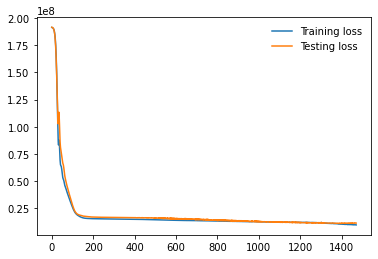

Эпоха 0 - train loss: 191199504.0, test loss: 191306064.0
Эпоха 100 - train loss: 23901622.0, test loss: 25616734.0
Эпоха 200 - train loss: 15526760.0, test loss: 17071720.0
Эпоха 300 - train loss: 15225288.0, test loss: 16705497.0
Эпоха 400 - train loss: 14983306.0, test loss: 16491719.0
Эпоха 500 - train loss: 14533743.0, test loss: 16369083.0
Эпоха 600 - train loss: 13855813.0, test loss: 15977740.0
Эпоха 700 - train loss: 13354219.0, test loss: 14916900.0
Эпоха 800 - train loss: 12821831.0, test loss: 14145799.0
Эпоха 900 - train loss: 12195743.0, test loss: 12418847.0
Эпоха 1000 - train loss: 11948357.0, test loss: 11739074.0
Эпоха 1100 - train loss: 11730259.0, test loss: 11695263.0
Early stopping at epoch 1105


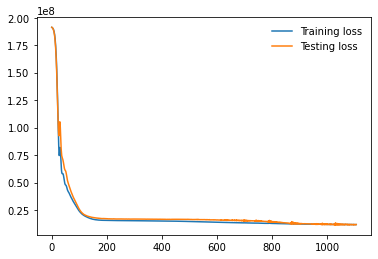

Эпоха 0 - train loss: 191252096.0, test loss: 191386256.0
Эпоха 100 - train loss: 26730946.0, test loss: 29458312.0
Эпоха 200 - train loss: 15629652.0, test loss: 16982566.0
Эпоха 300 - train loss: 15167986.0, test loss: 16348245.0
Эпоха 400 - train loss: 14647679.0, test loss: 16414609.0
Эпоха 500 - train loss: 13653041.0, test loss: 15111327.0
Эпоха 600 - train loss: 12396197.0, test loss: 11402322.0
Эпоха 700 - train loss: 11986018.0, test loss: 11127497.0
Early stopping at epoch 776


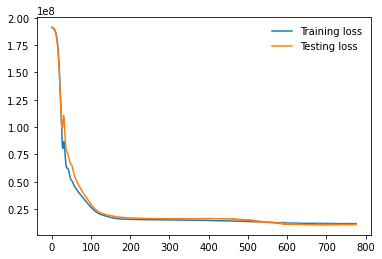

Эпоха 0 - train loss: 191218000.0, test loss: 191427168.0
Эпоха 100 - train loss: 37839756.0, test loss: 43799348.0
Эпоха 200 - train loss: 17828628.0, test loss: 18992282.0
Эпоха 300 - train loss: 15592141.0, test loss: 16991280.0
Эпоха 400 - train loss: 15371804.0, test loss: 16764594.0
Эпоха 500 - train loss: 15274417.0, test loss: 16716759.0
Эпоха 600 - train loss: 15196442.0, test loss: 16662215.0
Эпоха 700 - train loss: 15109381.0, test loss: 16650975.0
Эпоха 800 - train loss: 15013331.0, test loss: 16564200.0
Эпоха 900 - train loss: 14902685.0, test loss: 16487111.0
Эпоха 1000 - train loss: 14777742.0, test loss: 16445984.0
Эпоха 1100 - train loss: 14220893.0, test loss: 15890490.0
Эпоха 1200 - train loss: 12987359.0, test loss: 13979079.0
Эпоха 1300 - train loss: 11458373.0, test loss: 11490036.0
Эпоха 1400 - train loss: 10265363.0, test loss: 10161598.0
Эпоха 1500 - train loss: 9799767.0, test loss: 10337401.0
Early stopping at epoch 1522


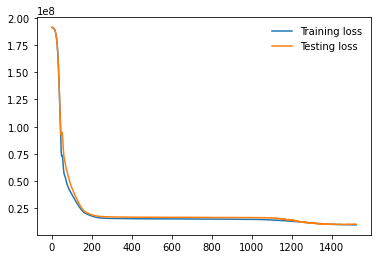

Эпоха 0 - train loss: 191211088.0, test loss: 191411056.0
Эпоха 100 - train loss: 29042152.0, test loss: 32327420.0
Эпоха 200 - train loss: 16137095.0, test loss: 17514140.0
Эпоха 300 - train loss: 15475974.0, test loss: 16790008.0
Эпоха 400 - train loss: 15312651.0, test loss: 16633440.0
Эпоха 500 - train loss: 15170807.0, test loss: 16502093.0
Эпоха 600 - train loss: 15013474.0, test loss: 16364104.0
Эпоха 700 - train loss: 14833154.0, test loss: 16155897.0
Эпоха 800 - train loss: 14600310.0, test loss: 16096435.0
Эпоха 900 - train loss: 14333314.0, test loss: 15909833.0
Эпоха 1000 - train loss: 14050937.0, test loss: 15458996.0
Эпоха 1100 - train loss: 13827612.0, test loss: 15195629.0
Эпоха 1200 - train loss: 13454884.0, test loss: 14615514.0
Early stopping at epoch 1251


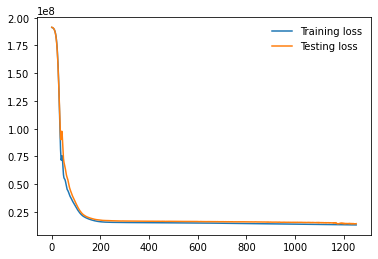

Эпоха 0 - train loss: 191233072.0, test loss: 191424224.0
Эпоха 100 - train loss: 30262106.0, test loss: 33437722.0
Эпоха 200 - train loss: 15810248.0, test loss: 17132144.0
Эпоха 300 - train loss: 15395402.0, test loss: 16569863.0
Эпоха 400 - train loss: 15187930.0, test loss: 16391917.0
Эпоха 500 - train loss: 14853915.0, test loss: 16174542.0
Эпоха 600 - train loss: 14399514.0, test loss: 15629773.0
Эпоха 700 - train loss: 13846616.0, test loss: 15045892.0
Эпоха 800 - train loss: 13500831.0, test loss: 14102181.0
Эпоха 900 - train loss: 13296152.0, test loss: 13671777.0
Эпоха 1000 - train loss: 13226575.0, test loss: 13864262.0
Early stopping at epoch 1099


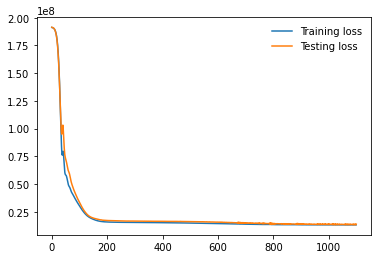

Эпоха 0 - train loss: 191244656.0, test loss: 191446288.0
Эпоха 100 - train loss: 30817528.0, test loss: 34769184.0
Эпоха 200 - train loss: 16397711.0, test loss: 17898754.0
Эпоха 300 - train loss: 15526680.0, test loss: 16825486.0
Эпоха 400 - train loss: 15320927.0, test loss: 16467321.0
Эпоха 500 - train loss: 15170814.0, test loss: 16332772.0
Эпоха 600 - train loss: 15001290.0, test loss: 16280152.0
Эпоха 700 - train loss: 14810217.0, test loss: 16118074.0
Early stopping at epoch 776


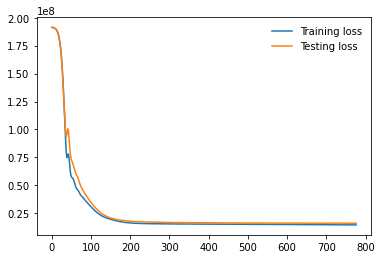

Эпоха 0 - train loss: 191237904.0, test loss: 191361520.0
Эпоха 100 - train loss: 29065748.0, test loss: 32204558.0
Эпоха 200 - train loss: 15758993.0, test loss: 17344094.0
Эпоха 300 - train loss: 15389457.0, test loss: 16642601.0
Эпоха 400 - train loss: 15219037.0, test loss: 16423941.0
Эпоха 500 - train loss: 15027146.0, test loss: 16203288.0
Эпоха 600 - train loss: 14730282.0, test loss: 15813760.0
Эпоха 700 - train loss: 14107966.0, test loss: 15033560.0
Эпоха 800 - train loss: 13173994.0, test loss: 14514505.0
Эпоха 900 - train loss: 12168981.0, test loss: 12918519.0
Эпоха 1000 - train loss: 11624162.0, test loss: 12690052.0
Эпоха 1100 - train loss: 11171623.0, test loss: 12031625.0
Эпоха 1200 - train loss: 10421155.0, test loss: 11671301.0
Early stopping at epoch 1295


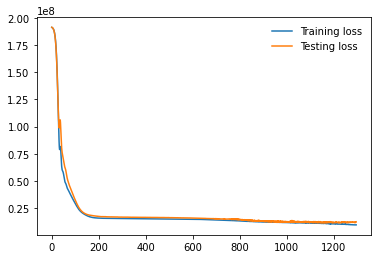

Эпоха 0 - train loss: 191278608.0, test loss: 191450960.0
Эпоха 100 - train loss: 26320064.0, test loss: 28529160.0
Эпоха 200 - train loss: 15448884.0, test loss: 17120926.0
Эпоха 300 - train loss: 14681204.0, test loss: 16470001.0
Эпоха 400 - train loss: 12814203.0, test loss: 14347507.0
Эпоха 500 - train loss: 11112416.0, test loss: 12178479.0
Эпоха 600 - train loss: 10103351.0, test loss: 11929838.0
Early stopping at epoch 616


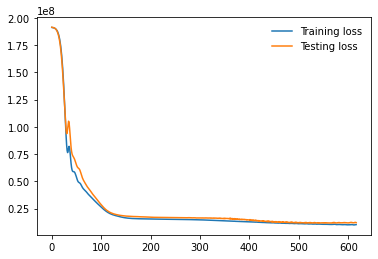

Эпоха 0 - train loss: 191314784.0, test loss: 191532720.0
Эпоха 100 - train loss: 34754568.0, test loss: 39610812.0
Эпоха 200 - train loss: 16746574.0, test loss: 17955456.0
Эпоха 300 - train loss: 15563966.0, test loss: 16782438.0
Эпоха 400 - train loss: 15402674.0, test loss: 16647339.0
Эпоха 500 - train loss: 15285404.0, test loss: 16542005.0
Эпоха 600 - train loss: 15172133.0, test loss: 16500038.0
Early stopping at epoch 689


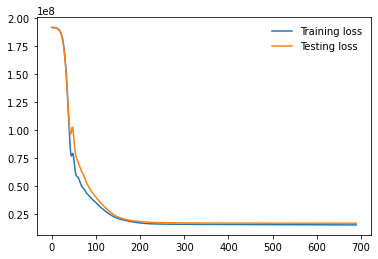

Эпоха 0 - train loss: 191347248.0, test loss: 191495792.0
Эпоха 100 - train loss: 27965822.0, test loss: 30614044.0
Эпоха 200 - train loss: 15525438.0, test loss: 17103634.0
Эпоха 300 - train loss: 15060181.0, test loss: 16557307.0
Эпоха 400 - train loss: 14344691.0, test loss: 16573070.0
Early stopping at epoch 413


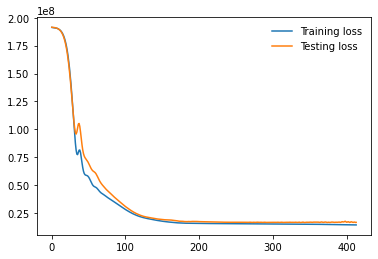

Эпоха 0 - train loss: 191157328.0, test loss: 191303296.0
Эпоха 100 - train loss: 24267356.0, test loss: 26331980.0
Эпоха 200 - train loss: 15703255.0, test loss: 17358744.0
Эпоха 300 - train loss: 15409453.0, test loss: 16926428.0
Эпоха 400 - train loss: 15290824.0, test loss: 16738756.0
Эпоха 500 - train loss: 15151663.0, test loss: 16839382.0
Early stopping at epoch 501


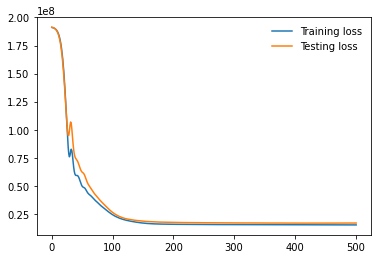

Эпоха 0 - train loss: 191270960.0, test loss: 191460992.0
Эпоха 100 - train loss: 30601834.0, test loss: 34451548.0
Эпоха 200 - train loss: 16055410.0, test loss: 18140996.0
Эпоха 300 - train loss: 15465373.0, test loss: 17710198.0
Эпоха 400 - train loss: 15317225.0, test loss: 17563096.0
Эпоха 500 - train loss: 15167203.0, test loss: 17340890.0
Эпоха 600 - train loss: 14961636.0, test loss: 16996028.0
Эпоха 700 - train loss: 14511812.0, test loss: 16523425.0
Эпоха 800 - train loss: 13825413.0, test loss: 15769083.0
Эпоха 900 - train loss: 11942019.0, test loss: 14098715.0
Эпоха 1000 - train loss: 10606406.0, test loss: 13839844.0
Early stopping at epoch 1035


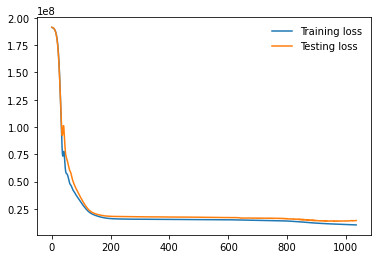

Эпоха 0 - train loss: 191231328.0, test loss: 191379872.0
Эпоха 100 - train loss: 31335058.0, test loss: 35487972.0
Эпоха 200 - train loss: 16365191.0, test loss: 18126716.0
Эпоха 300 - train loss: 15423815.0, test loss: 16966950.0
Эпоха 400 - train loss: 15105610.0, test loss: 16850644.0
Эпоха 500 - train loss: 14532846.0, test loss: 15581203.0
Эпоха 600 - train loss: 13606828.0, test loss: 13954213.0
Эпоха 700 - train loss: 13096373.0, test loss: 12731422.0
Эпоха 800 - train loss: 12704469.0, test loss: 11359633.0
Эпоха 900 - train loss: 12461663.0, test loss: 10933097.0
Эпоха 1000 - train loss: 12449381.0, test loss: 10606382.0
Early stopping at epoch 1080


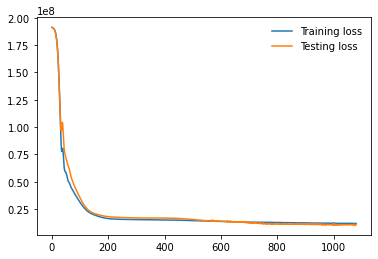

Эпоха 0 - train loss: 191315152.0, test loss: 191522416.0
Эпоха 100 - train loss: 27283640.0, test loss: 29509468.0
Эпоха 200 - train loss: 15847800.0, test loss: 17437480.0
Эпоха 300 - train loss: 15442027.0, test loss: 17105686.0
Early stopping at epoch 396


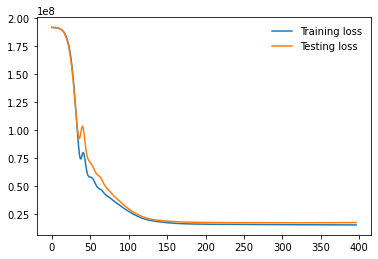

Эпоха 0 - train loss: 191313888.0, test loss: 191501520.0
Эпоха 100 - train loss: 33091258.0, test loss: 37578820.0
Эпоха 200 - train loss: 16455282.0, test loss: 18048924.0
Эпоха 300 - train loss: 15521722.0, test loss: 17048140.0
Эпоха 400 - train loss: 15376877.0, test loss: 16791478.0
Эпоха 500 - train loss: 15197883.0, test loss: 16774554.0
Early stopping at epoch 528


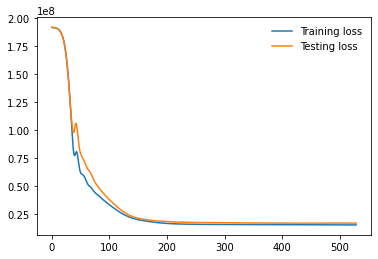

Эпоха 0 - train loss: 191342976.0, test loss: 191510400.0
Эпоха 100 - train loss: 28915722.0, test loss: 31621288.0
Эпоха 200 - train loss: 15645163.0, test loss: 17276944.0
Эпоха 300 - train loss: 15054702.0, test loss: 16858754.0
Эпоха 400 - train loss: 14088377.0, test loss: 16608335.0
Эпоха 500 - train loss: 12132961.0, test loss: 13679224.0
Эпоха 600 - train loss: 10421773.0, test loss: 13577359.0
Early stopping at epoch 608


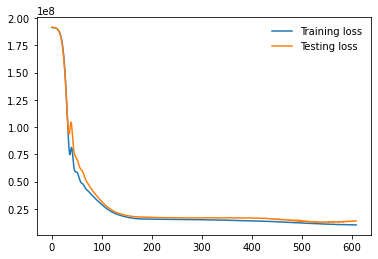

Эпоха 0 - train loss: 191214656.0, test loss: 191363008.0
Эпоха 100 - train loss: 25177588.0, test loss: 27853806.0
Эпоха 200 - train loss: 15666037.0, test loss: 17137888.0
Эпоха 300 - train loss: 15338028.0, test loss: 16587992.0
Эпоха 400 - train loss: 15017020.0, test loss: 16478989.0
Эпоха 500 - train loss: 14415804.0, test loss: 16255153.0
Эпоха 600 - train loss: 13573089.0, test loss: 15779464.0
Эпоха 700 - train loss: 12191342.0, test loss: 14411720.0
Эпоха 800 - train loss: 10347078.0, test loss: 14154132.0
Early stopping at epoch 836


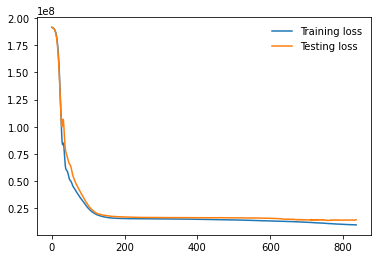

Эпоха 0 - train loss: 191228176.0, test loss: 191348544.0
Эпоха 100 - train loss: 22559848.0, test loss: 24160772.0
Эпоха 200 - train loss: 15603027.0, test loss: 17139842.0
Эпоха 300 - train loss: 15339751.0, test loss: 16832478.0
Эпоха 400 - train loss: 15126165.0, test loss: 16732485.0
Эпоха 500 - train loss: 14731444.0, test loss: 16718734.0
Эпоха 600 - train loss: 14262971.0, test loss: 16383073.0
Эпоха 700 - train loss: 13854884.0, test loss: 15511623.0
Эпоха 800 - train loss: 13563129.0, test loss: 15048344.0
Эпоха 900 - train loss: 13337259.0, test loss: 14477321.0
Эпоха 1000 - train loss: 13078351.0, test loss: 14275886.0
Эпоха 1100 - train loss: 11579533.0, test loss: 12139604.0
Эпоха 1200 - train loss: 10352943.0, test loss: 11550426.0
Early stopping at epoch 1266


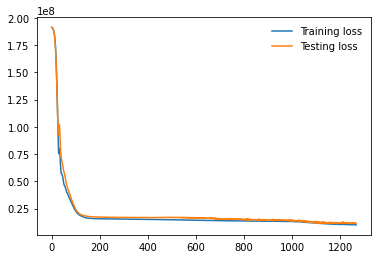

Эпоха 0 - train loss: 191243040.0, test loss: 191376256.0
Эпоха 100 - train loss: 23397278.0, test loss: 25481540.0
Эпоха 200 - train loss: 15710175.0, test loss: 17528956.0
Эпоха 300 - train loss: 15243869.0, test loss: 16782160.0
Эпоха 400 - train loss: 14740202.0, test loss: 16145997.0
Эпоха 500 - train loss: 13307874.0, test loss: 15053056.0
Эпоха 600 - train loss: 11890894.0, test loss: 13165428.0
Early stopping at epoch 692


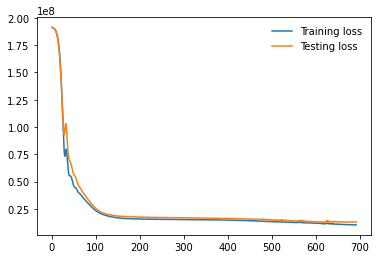

Эпоха 0 - train loss: 191281648.0, test loss: 191410208.0
Эпоха 100 - train loss: 21054278.0, test loss: 22645686.0
Эпоха 200 - train loss: 15680066.0, test loss: 16921264.0
Эпоха 300 - train loss: 15368019.0, test loss: 16611684.0
Эпоха 400 - train loss: 14707743.0, test loss: 16483432.0
Эпоха 500 - train loss: 13836749.0, test loss: 15328849.0
Эпоха 600 - train loss: 12663051.0, test loss: 14656744.0
Early stopping at epoch 627


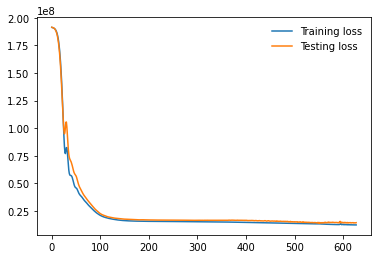

Эпоха 0 - train loss: 191267216.0, test loss: 191454912.0
Эпоха 100 - train loss: 31047222.0, test loss: 34768036.0
Эпоха 200 - train loss: 16275603.0, test loss: 17596780.0
Эпоха 300 - train loss: 15449786.0, test loss: 16690778.0
Эпоха 400 - train loss: 15272795.0, test loss: 16595694.0
Эпоха 500 - train loss: 15122932.0, test loss: 16556884.0
Early stopping at epoch 511


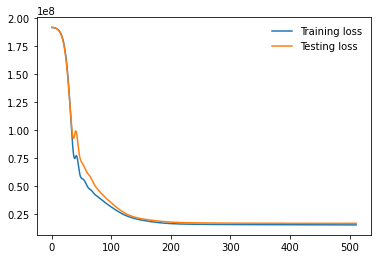

Эпоха 0 - train loss: 191266064.0, test loss: 191462688.0
Эпоха 100 - train loss: 27532404.0, test loss: 30417968.0
Эпоха 200 - train loss: 15960023.0, test loss: 17343352.0
Эпоха 300 - train loss: 15529700.0, test loss: 16904132.0
Early stopping at epoch 386


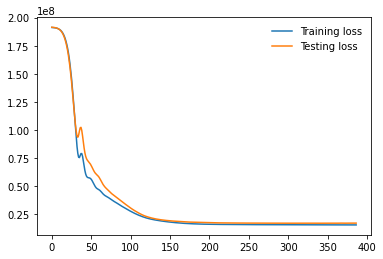

Эпоха 0 - train loss: 191271024.0, test loss: 191433872.0
Эпоха 100 - train loss: 23949100.0, test loss: 25361328.0
Эпоха 200 - train loss: 15580127.0, test loss: 17049278.0
Эпоха 300 - train loss: 15256303.0, test loss: 16589515.0
Эпоха 400 - train loss: 14918791.0, test loss: 16310955.0
Эпоха 500 - train loss: 14211151.0, test loss: 15726936.0
Эпоха 600 - train loss: 13454156.0, test loss: 15109925.0
Эпоха 700 - train loss: 12812812.0, test loss: 14524271.0
Эпоха 800 - train loss: 12010467.0, test loss: 14324454.0
Early stopping at epoch 812


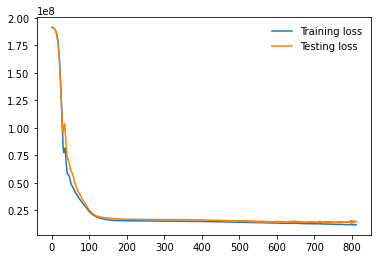

Эпоха 0 - train loss: 191273568.0, test loss: 191480688.0
Эпоха 100 - train loss: 27893872.0, test loss: 30996604.0
Эпоха 200 - train loss: 15751648.0, test loss: 17135960.0
Эпоха 300 - train loss: 15195791.0, test loss: 16482642.0
Эпоха 400 - train loss: 14532898.0, test loss: 16155686.0
Эпоха 500 - train loss: 13510035.0, test loss: 15370027.0
Эпоха 600 - train loss: 12057836.0, test loss: 14204279.0
Эпоха 700 - train loss: 10786150.0, test loss: 13776114.0
Early stopping at epoch 781


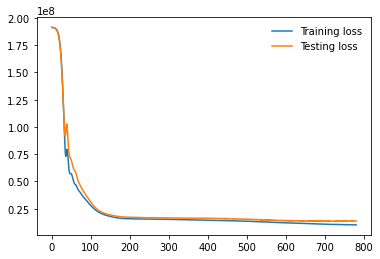

Эпоха 0 - train loss: 191274976.0, test loss: 191452256.0
Эпоха 100 - train loss: 24690146.0, test loss: 26728726.0
Эпоха 200 - train loss: 15817643.0, test loss: 17449924.0
Эпоха 300 - train loss: 15488055.0, test loss: 16916542.0
Эпоха 400 - train loss: 15352191.0, test loss: 16887988.0
Early stopping at epoch 431


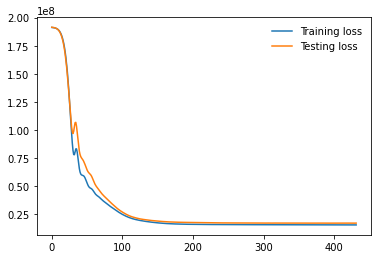

Эпоха 0 - train loss: 191334560.0, test loss: 191472928.0
Эпоха 100 - train loss: 19916722.0, test loss: 21136372.0
Эпоха 200 - train loss: 15396726.0, test loss: 17192594.0
Эпоха 300 - train loss: 14888222.0, test loss: 17104008.0
Эпоха 400 - train loss: 14105370.0, test loss: 16734005.0
Эпоха 500 - train loss: 12856571.0, test loss: 15552297.0
Эпоха 600 - train loss: 11080703.0, test loss: 13454053.0
Эпоха 700 - train loss: 9583986.0, test loss: 12084782.0
Эпоха 800 - train loss: 9005548.0, test loss: 11812506.0
Эпоха 900 - train loss: 8830876.0, test loss: 11813685.0
Early stopping at epoch 973


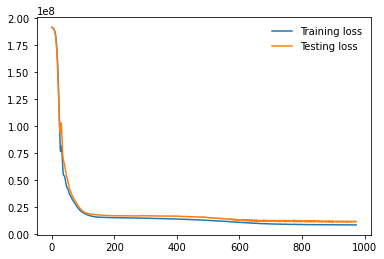

Эпоха 0 - train loss: 191220048.0, test loss: 191335136.0
Эпоха 100 - train loss: 23128684.0, test loss: 25346662.0
Эпоха 200 - train loss: 15579386.0, test loss: 17130432.0
Эпоха 300 - train loss: 15324278.0, test loss: 16856678.0
Эпоха 400 - train loss: 15097076.0, test loss: 16714839.0
Эпоха 500 - train loss: 14704128.0, test loss: 16268110.0
Эпоха 600 - train loss: 13808420.0, test loss: 15960987.0
Эпоха 700 - train loss: 12900317.0, test loss: 16134209.0
Эпоха 800 - train loss: 12086949.0, test loss: 15902603.0
Эпоха 900 - train loss: 11432061.0, test loss: 15581542.0
Эпоха 1000 - train loss: 11045536.0, test loss: 15623806.0
Эпоха 1100 - train loss: 12931046.0, test loss: 16953376.0
Эпоха 1200 - train loss: 10308510.0, test loss: 15053860.0
Эпоха 1300 - train loss: 9955643.0, test loss: 13750974.0
Эпоха 1400 - train loss: 9739776.0, test loss: 13646970.0
Эпоха 1500 - train loss: 10020777.0, test loss: 13232078.0
Эпоха 1600 - train loss: 10143935.0, test loss: 12966283.0
Early sto

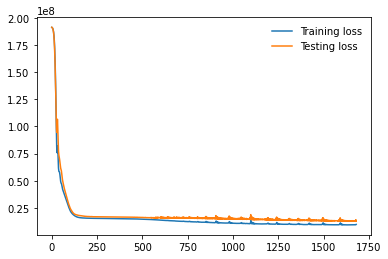

Эпоха 0 - train loss: 191246336.0, test loss: 191426864.0
Эпоха 100 - train loss: 22381126.0, test loss: 24586624.0
Эпоха 200 - train loss: 15496529.0, test loss: 17610200.0
Эпоха 300 - train loss: 14947512.0, test loss: 16959650.0
Эпоха 400 - train loss: 14331771.0, test loss: 16635596.0
Эпоха 500 - train loss: 13309768.0, test loss: 15029640.0
Эпоха 600 - train loss: 11798118.0, test loss: 12887809.0
Early stopping at epoch 688


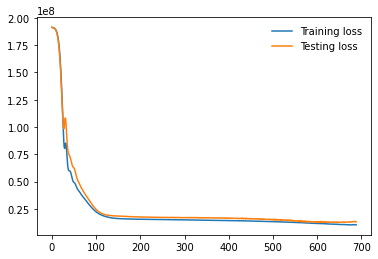

Эпоха 0 - train loss: 191381488.0, test loss: 191520128.0
Эпоха 100 - train loss: 23690980.0, test loss: 26186506.0
Эпоха 200 - train loss: 15413402.0, test loss: 17118638.0
Эпоха 300 - train loss: 14809268.0, test loss: 16755432.0
Эпоха 400 - train loss: 13759456.0, test loss: 16040653.0
Эпоха 500 - train loss: 12504236.0, test loss: 14404634.0
Эпоха 600 - train loss: 10377067.0, test loss: 11876205.0
Early stopping at epoch 677


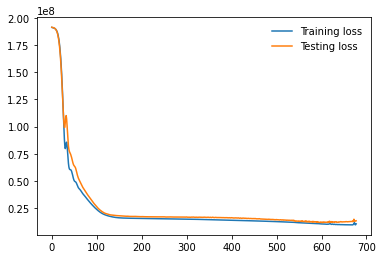

RMSE первичной модели: 3079.427978515625
Архитектура первичной модели: (20, 60, 60, 20)
CPU times: user 8min 44s, sys: 3.26 s, total: 8min 47s
Wall time: 8min 54s


In [25]:
%%time

neurons_per_layer = [20, 40, 60]
max_hidden_layers = 4

best_rmse = float('inf')
best_model_structure = None

layer_structures = list(itertools.product(neurons_per_layer, repeat=max_hidden_layers))

for layer_structure in layer_structures:
    model = StarTempPredictor(layer_structure)
    model.apply(init_weights)
    
    model, train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)
    
    with torch.no_grad():
        model.eval()
        predictions = model(X_test)
        mse = F.mse_loss(predictions, y_test)
        rmse = torch.sqrt(mse).item()

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_structure = layer_structure
            primary_model = model

    # Plot losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Testing loss')
    plt.legend(frameon=False)
    plt.show()

print('RMSE первичной модели:', best_rmse)
print('Архитектура первичной модели:', best_model_structure)

### Строим график "Факт-Прогноз".

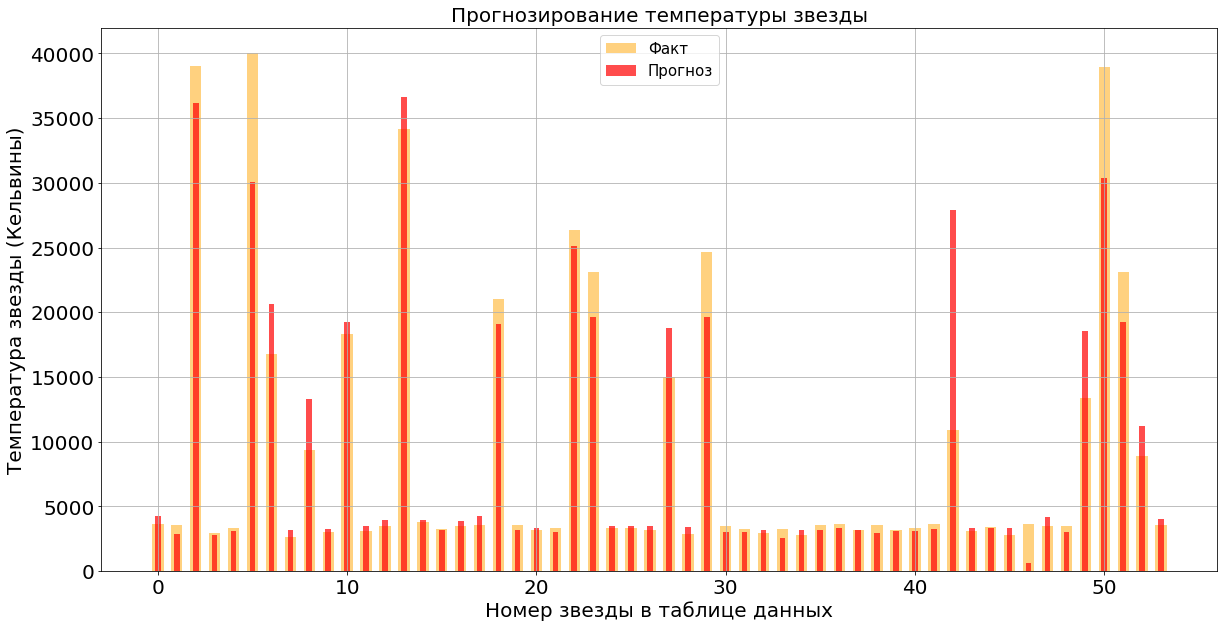

In [26]:
predictions = primary_model(X_test)
mse = F.mse_loss(predictions, y_test)
rmse = torch.sqrt(mse).item()

# Перевод модели в режим тестирования
model.eval()

# Получение прогнозов модели на тестовом наборе данных
predictions = model(X_test)

# Номера звезд для оси X
stars = np.arange(len(y_test))

# Фактические и прогнозируемые значения
y_test_np = y_test.detach().numpy().flatten()
predictions_np = predictions.detach().numpy().flatten()

# Размеры фигуры
plt.figure(figsize=(20, 10))

# Построение графика для фактических значений с оранжевыми столбцами
plt.bar(stars, y_test_np, width=0.6, label='Факт', color='orange', alpha=0.5)

# Построение графика для прогнозируемых значений с красными столбцами, накладывающимися по центру столбцов фактических данных
plt.bar(stars, predictions_np, width=0.3, label='Прогноз', color='red', alpha=0.7)

plt.title('Прогнозирование температуры звезды', fontsize=20)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды (Кельвины)', fontsize=20)
plt.legend(fontsize=15)

# Увеличение размера шрифта значений по осям
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.show()


### Вывод:

- Модель довольно дает приемлемые (за редким исключением) по точности предсказания относительно объектов, фактическая температура которых не превышает 10000 Кельвинов.
- Вместе с тем, точность предсказаний модели существенно снижается в отношении объектов, фактическая температура которых превышает 10000 Кельвинов.

## Улучшение нейронной сети

### Воссоздаем нейросеть с архитектурой, подобранной на предыдущем этапе.¶

In [30]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25, 20)
        self.fc2 = nn.Linear(20, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 20)
        self.fc5 = nn.Linear(20, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x.squeeze()  


### Создаем решение с перебором параметров нейронной сети.¶

Эпоха 0 - train loss: 191234976.0, test loss: 191375040.0
Эпоха 100 - train loss: 31386362.0, test loss: 28687616.0
Эпоха 200 - train loss: 22465384.0, test loss: 19888772.0
Early stopping at epoch 282


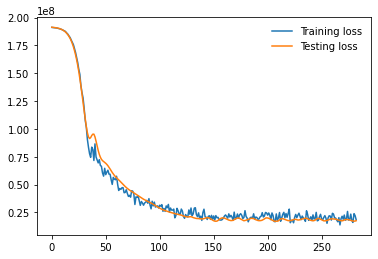

Эпоха 0 - train loss: 191194768.0, test loss: 191349632.0
Эпоха 100 - train loss: 28178788.0, test loss: 28649762.0
Эпоха 200 - train loss: 22841766.0, test loss: 16930806.0
Эпоха 300 - train loss: 18742692.0, test loss: 18590230.0
Early stopping at epoch 318


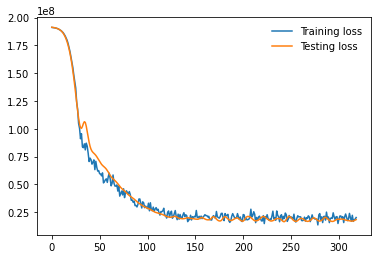

Эпоха 0 - train loss: 191225264.0, test loss: 191356720.0
Эпоха 100 - train loss: 32070730.0, test loss: 30603496.0
Эпоха 200 - train loss: 22738886.0, test loss: 17214952.0
Эпоха 300 - train loss: 19081612.0, test loss: 19461312.0
Early stopping at epoch 304


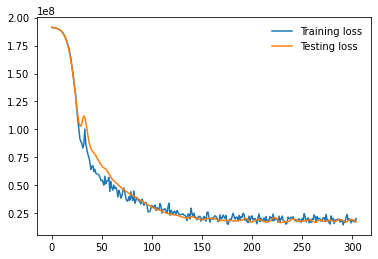

Эпоха 0 - train loss: 191337120.0, test loss: 191508080.0
Эпоха 100 - train loss: 41953840.0, test loss: 29642504.0
Эпоха 200 - train loss: 29389040.0, test loss: 21926156.0
Early stopping at epoch 270


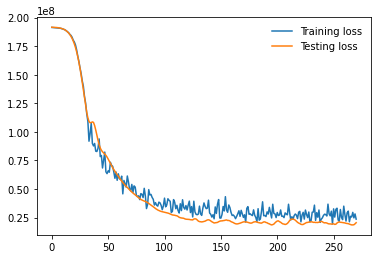

Эпоха 0 - train loss: 191289424.0, test loss: 191457648.0
Эпоха 100 - train loss: 41871580.0, test loss: 27632712.0
Эпоха 200 - train loss: 28105876.0, test loss: 21179256.0
Early stopping at epoch 265


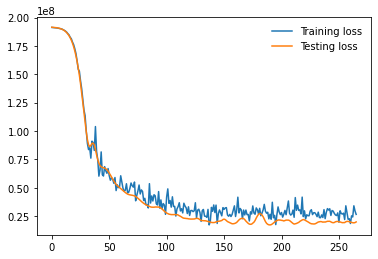

Эпоха 0 - train loss: 191262128.0, test loss: 191465296.0
Эпоха 100 - train loss: 51483408.0, test loss: 34392864.0
Эпоха 200 - train loss: 29434314.0, test loss: 24007818.0
Эпоха 300 - train loss: 26814374.0, test loss: 20809088.0
Эпоха 400 - train loss: 21591144.0, test loss: 17465306.0
Early stopping at epoch 442


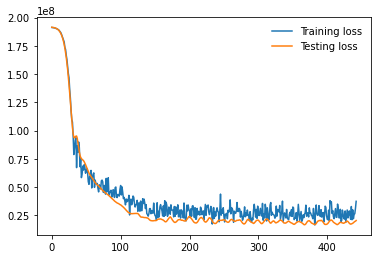

Эпоха 0 - train loss: 191308848.0, test loss: 191495456.0
Эпоха 100 - train loss: 49183016.0, test loss: 46504624.0
Эпоха 200 - train loss: 46420576.0, test loss: 28467298.0
Early stopping at epoch 267


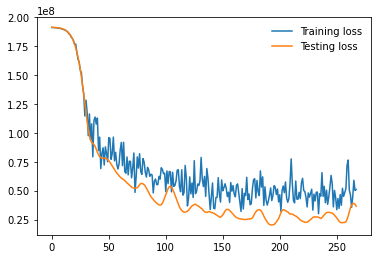

Эпоха 0 - train loss: 191213056.0, test loss: 191419536.0
Эпоха 100 - train loss: 70000576.0, test loss: 43390368.0
Эпоха 200 - train loss: 50788164.0, test loss: 27181824.0
Эпоха 300 - train loss: 41119480.0, test loss: 27193234.0
Early stopping at epoch 311


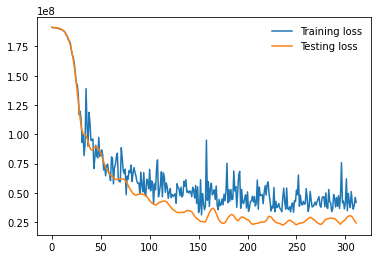

Эпоха 0 - train loss: 191151936.0, test loss: 191375136.0
Эпоха 100 - train loss: 62273208.0, test loss: 31135268.0
Эпоха 200 - train loss: 37512772.0, test loss: 25429620.0
Early stopping at epoch 235


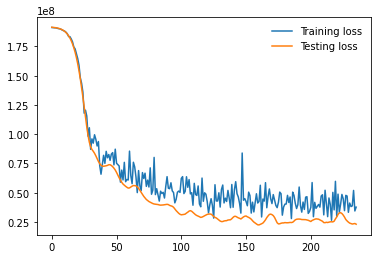

RMSE финальной модели: 4050.8671875
Настройки финальной модели (Dropout, Batch size): (0.1, 32)
CPU times: user 29.6 s, sys: 165 ms, total: 29.8 s
Wall time: 30 s


In [31]:
%%time

dropout_values = [0.1, 0.25, 0.5]
batch_sizes = [16, 32, 64]

best_rmse = float('inf')
best_model_structure = None

for dropout in dropout_values:
    for batch_size in batch_sizes:
        model = Net(dropout)
        model.apply(init_weights)
        
        loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size)
        X_train_batches, y_train_batches = zip(*list(loader))
        X_train_batches, y_train_batches = torch.cat(X_train_batches), torch.cat(y_train_batches)

        model, train_losses, test_losses = train_model(model, X_train_batches, y_train_batches, X_test, y_test)
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_test)
            mse = F.mse_loss(predictions, y_test)
            rmse = torch.sqrt(mse).item()

            if rmse < best_rmse:
                best_rmse = rmse
                best_model_structure = (dropout, batch_size)
                final_model = model

        # Plot losses
        plt.plot(train_losses, label='Training loss')
        plt.plot(test_losses, label='Testing loss')
        plt.legend(frameon=False)
        plt.show()

print('RMSE финальной модели:', best_rmse)
print('Настройки финальной модели (Dropout, Batch size):', best_model_structure)

### Строим график "Факт-Прогноз".

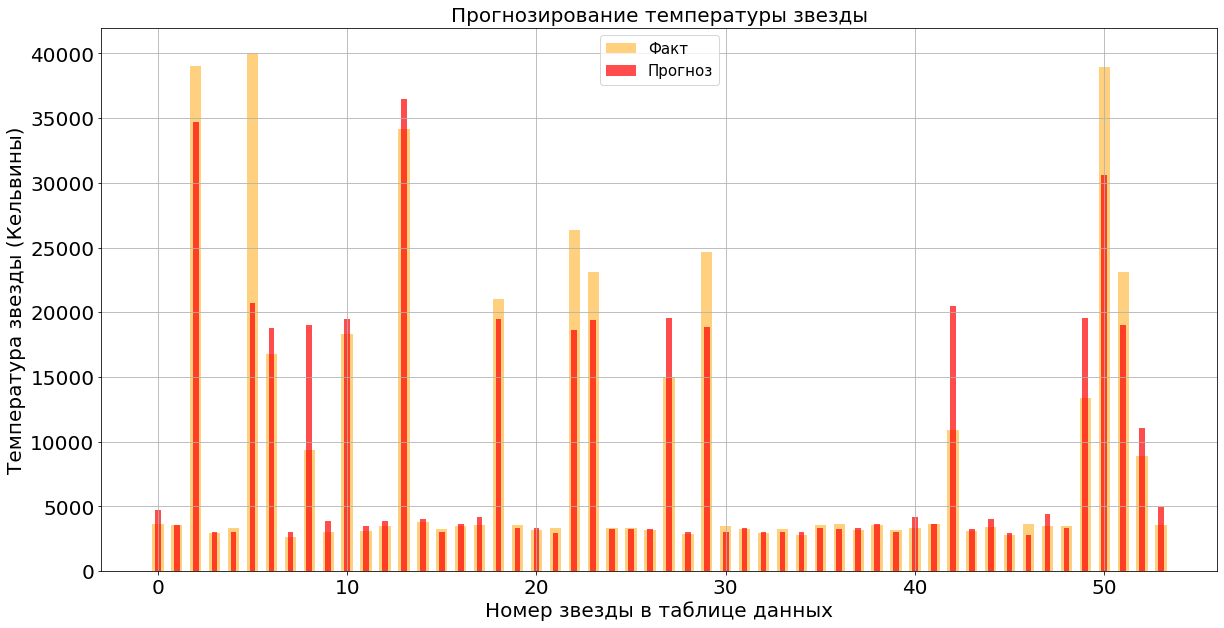

In [29]:
# Перевод модели в режим тестирования
final_model.eval()

# Получение прогнозов модели на тестовом наборе данных
predictions = final_model(X_test)

# Номера звезд для оси X
stars = np.arange(len(y_test))

# Фактические и прогнозируемые значения
y_test_np = y_test.detach().numpy().flatten()
predictions_np = predictions.detach().numpy().flatten()

# Размеры фигуры
plt.figure(figsize=(20, 10))

# Построение графика для фактических значений с оранжевыми столбцами
plt.bar(stars, y_test_np, width=0.6, label='Факт', color='orange', alpha=0.5)

# Построение графика для прогнозируемых значений с красными столбцами, накладывающимися по центру столбцов фактических данных
plt.bar(stars, predictions_np, width=0.3, label='Прогноз', color='red', alpha=0.7)

plt.title('Прогнозирование температуры звезды', fontsize=20)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды (Кельвины)', fontsize=20)
plt.legend(fontsize=15)

# Увеличение размера шрифта значений по осям
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.show()

### Вывод:

Регуляризация при помощи dropout и batches в данной случае не улучшила, а, наоборот, ухудшила качество модели.

## Выводы

- Нейросеть, подобранная изначально, позволила добиться метрики RMSE ≈ 3000 при целевой метрике 4500. В подборе оптимальных параметров нейросети очень сильно помогло внедрение алгоритма EarlyStopping и постепенное снижение learning rate.
- Добавление к выбранной нейросети параметров dropout и batches не привело к улучшению качества, а, наоборот, снизило целевую метрику RMSE до ≈ 4000, что, тем не менее, позволило достичь цели проекта.
- Таким образом, регуляризация не всегда приводит к улучшению качества нейросети.